<a href="https://colab.research.google.com/github/miltiadiss/Decision-Theory/blob/main/Project%201/TSLA_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Decision Theory**
#**Project 1: TSLA stock closing price prediction**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
desired_directory = '/content/drive/MyDrive/alphavantage' #define current directory in google drive
os.chdir(desired_directory)

Mounted at /content/drive


In [3]:
import requests

#API_KEY = YZFYJ9DASTWXPXOS
#STOCK_SYMBOL = TSLA

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=TSLA&outputsize=full&apikey=YZFYJ9DASTWXPXOS'
r = requests.get(url)
json_data = r.json()

#print(json_data)

The data that we will be using contain the **TSLA stock closing prices from 2010-06-29 until 2024-11-14**. The training test will contain data from 2010-06-29 until 2023-12-31 and the validation test after the training process will contain data from 2024-01-01 until 2024-11-14. So all the predictions will be made on new data that will start from date 2024-11-15.

In [4]:
import json
import csv
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt

# Extract "Time Series (Daily)" part from JSON
time_series = json_data.get("Time Series (Daily)", {})

# Prepare data for CSV
csv_data = [("Date", "Close")]  # Header for CSV file

# Loop through each date and get the "close" price
for date, daily_data in time_series.items():
    close_price = daily_data.get("4. close", None)
    if close_price:
        csv_data.append((date, close_price))

# Write data to CSV file
csv_file = 'close_prices.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Data saved to {csv_file}")

# Read CSV file and store the data in a DataFrame
df = pd.read_csv('close_prices.csv', parse_dates=['Date'])
df = df.sort_values(by='Date')  # Sorting by 'Date'

Data saved to close_prices.csv


In [5]:
df = df[df['Date']<='2024-11-14']

##**Data Preprocessing**

We will first use a **Gaussian Filter** in order to remove the outliers, denoise the data timeseries and locate hidden trends. The value of parameter sigma controls the width of the filter. Larger values of sigma result in smoother data, while smaller values preserve more information of the original data. **Since we are interested in short-term predictions, we will choose smaller values of sigma, such as 2 or 3. These values will reduce the noise without smoothing out important short-term variations needed for the daily predictions.** On the other hand, with a larger sigma the filter will take into account a larger window of past data values, leading to a much smoother time series with a loss of important short-term signals.

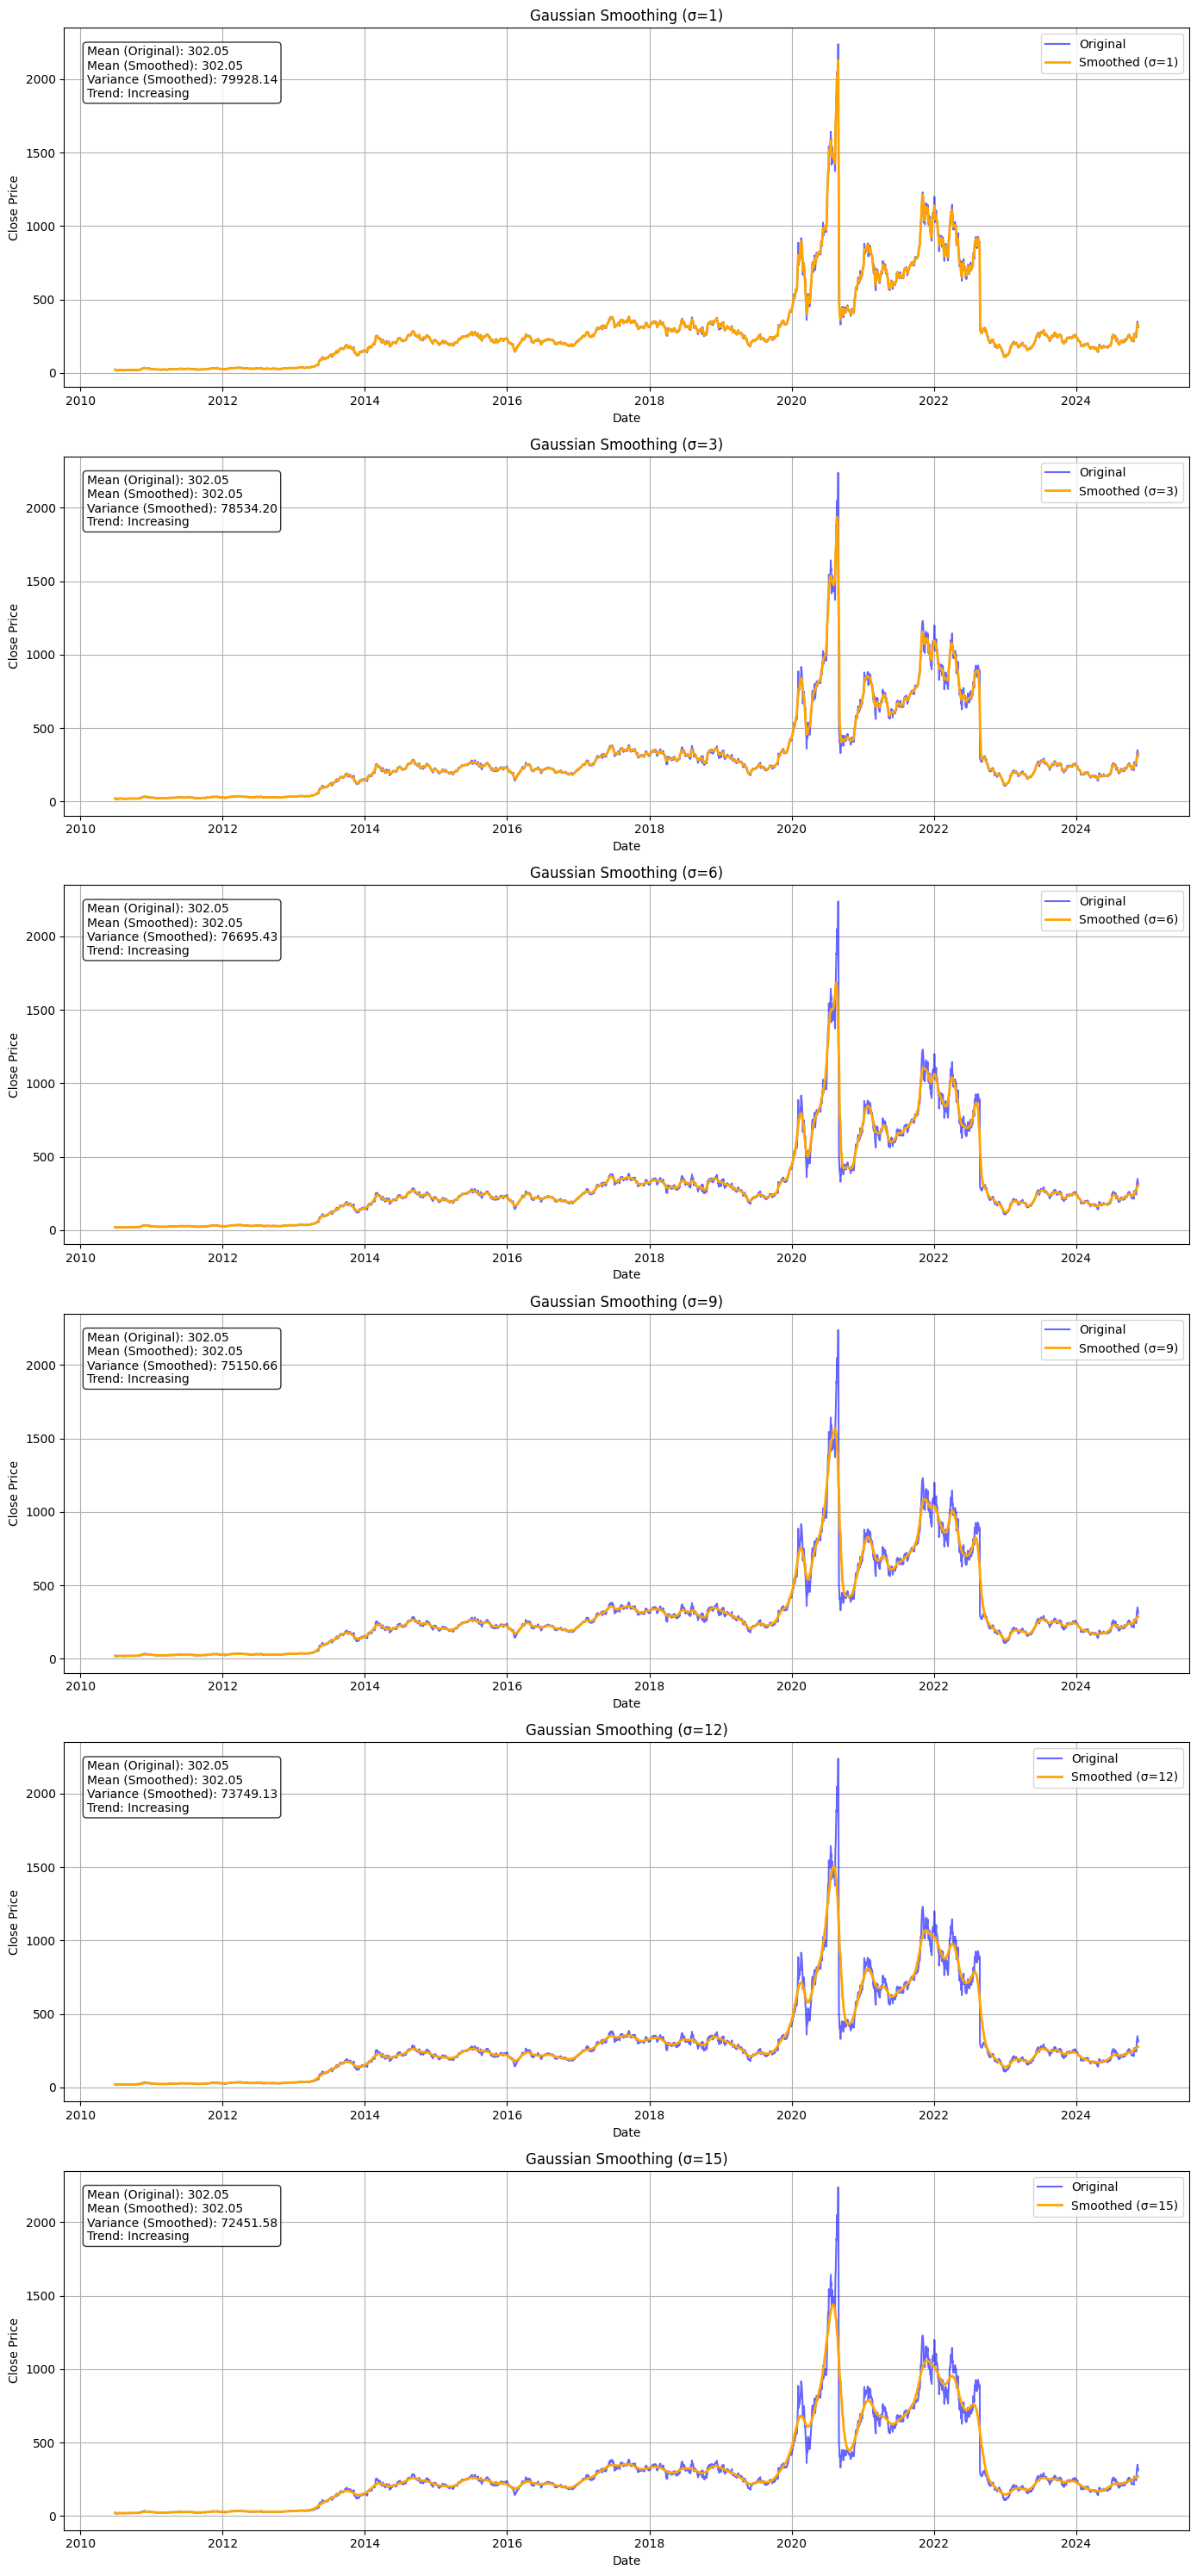

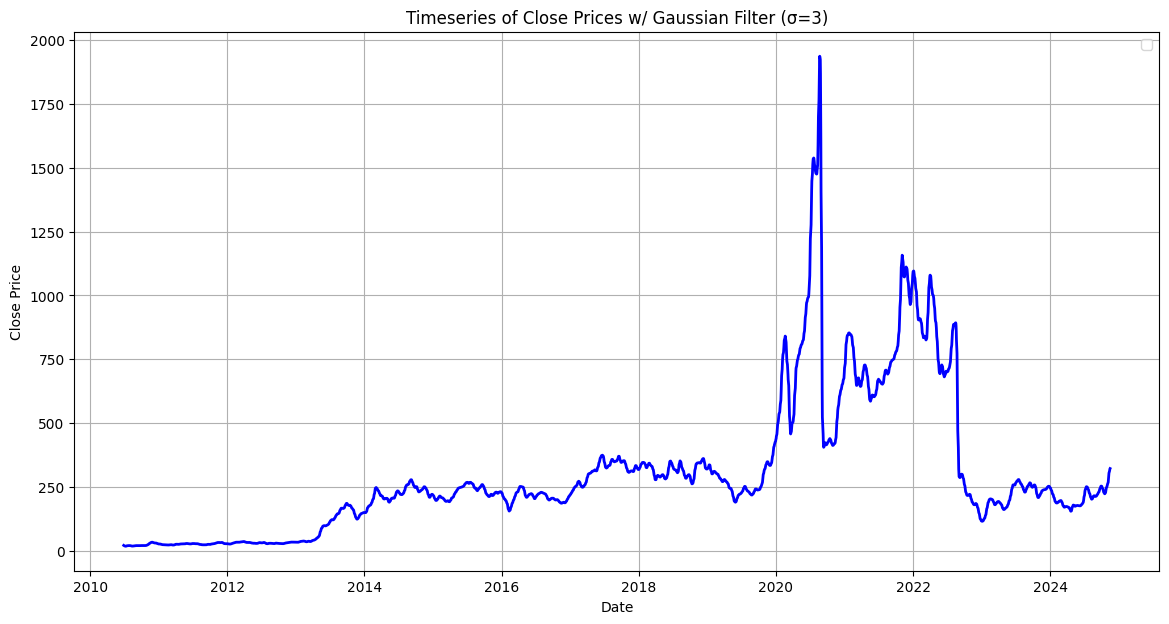

In [6]:
from scipy.stats import linregress

# Visualize original and smoothed timeseries for different values of sigma
sigma_values = [1, 3, 6, 9, 12, 15]
fig, axes = plt.subplots(len(sigma_values), 1, figsize=(14, 5 * len(sigma_values)))

for i, sigma in enumerate(sigma_values):
    # Apply Gaussian filter
    smoothed_close = gaussian_filter1d(df['Close'], sigma=sigma)

    # Compute statistics
    mean_original = np.mean(df['Close'])
    mean_smoothed = np.mean(smoothed_close)
    variance_smoothed = np.var(smoothed_close)

    # Calculate trend using linear regression on the smoothed data
    slope, intercept, _, _, _ = linregress(range(len(smoothed_close)), smoothed_close)
    trend = "Increasing" if slope > 0 else "Decreasing" if slope < 0 else "Flat"

    # Plot original and smoothed data
    axes[i].plot(df['Date'], df['Close'], label='Original', color='blue', linewidth=1.5, alpha=0.6)
    axes[i].plot(df['Date'], smoothed_close, label=f'Smoothed (σ={sigma})', color='orange', linewidth=2)

    # Display statistics on the plot
    stats_text = (
        f"Mean (Original): {mean_original:.2f}\n"
        f"Mean (Smoothed): {mean_smoothed:.2f}\n"
        f"Variance (Smoothed): {variance_smoothed:.2f}\n"
        f"Trend: {trend}"
    )
    axes[i].text(0.02, 0.95, stats_text, transform=axes[i].transAxes, fontsize=10, va='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

    # Formatting the subplot
    axes[i].set_title(f'Gaussian Smoothing (σ={sigma})')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Close Price')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Apply Gaussian Filter with the optimal sigma value
sigma = 3
df['Close'] = gaussian_filter1d(df['Close'], sigma=sigma)

# Plot the smoothed timeseries
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], color='blue', linewidth=2)

plt.title(f'Timeseries of Close Prices w/ Gaussian Filter (σ={sigma})')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

### **Observation**
TSLA stock closing prices exhibit a strong upward trend starting around 2019, which peaks in late 2021 before experiencing a significant drop in 2022. There are periods of high volatility, particularly during the 2020-2022 period, with sharp spikes and drops. This suggests that the stock had frequent fluctuations. After the significant drop in 2022, the closing prices seem to have stabilized, hovering around a lower price range in 2023-2024. Overall, this indicates that the target variable (closing stock price) has a strong dependency on recent, short-term changes rather than on smoothed, long-term trends. In essence, TSLA's price dynamics are better captured by a model that considers recent day-to-day variations, as these fluctuations hold more predictive value than a smoothed view of weekly trends, which would obscure the nuanced daily changes. **Therefore, we will choose to use the daily closing prices as features for the training of the model rather than the weekly averages.**

Particularly for year 2024 the data appear more stable compared to previous years, with no significant upward or downward trends. **Thus, a Linear Regression could be more adequate for making short-term predictions in data from 2024 of the validation set than a Polynomial Regression.** Higher-degree polynomials are at risk of overfitting, since the model is trained on the 2010-2023 data, which have more spikes and dips than the 2024 data.







##**Statistic Analysis**

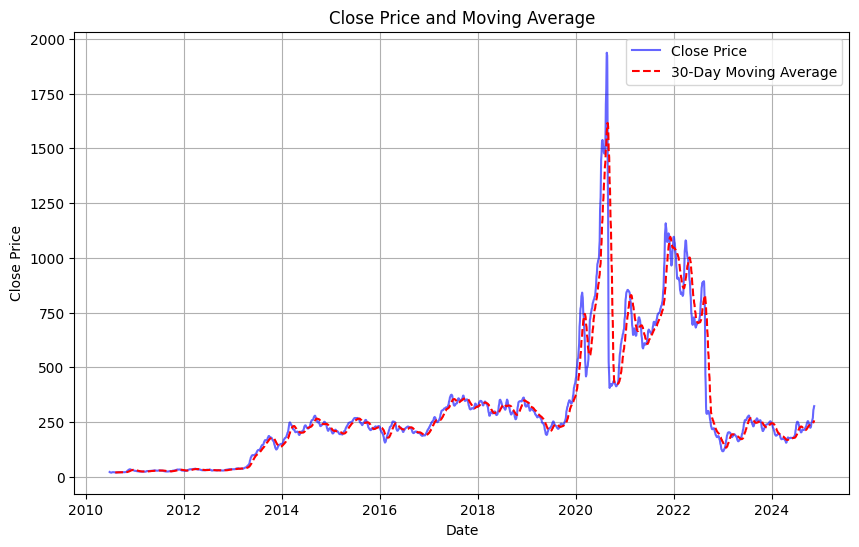

In [ ]:
# Calculate Simple Moving Average (SMA) with window size 30 days
SMA_30 = df['Close'].rolling(window=30).mean()

# Plot Close Prices with Moving Average
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(df['Date'], SMA_30, label='30-Day Moving Average', color='red', linestyle='--')
plt.title("Close Price and Moving Average")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

###**Observation**
Here the 30-day moving average smooths out daily fluctuations and captures the overall trend in the stock price. Again we verify that **the data timeseries show a long-term growth trend disrupted by a significant volatility spike in 2020 - 2021. This is followed by a correction and stabilization, with potential gradual recovery observed in recent months.**

We move on to the decomposition of the timeseries into **trend, seasonability and residuals** over a period of 365 days. This way we can see more clearly the general stock behavior and locate any predictable patterns in the stock price.

<Figure size 1000x800 with 0 Axes>

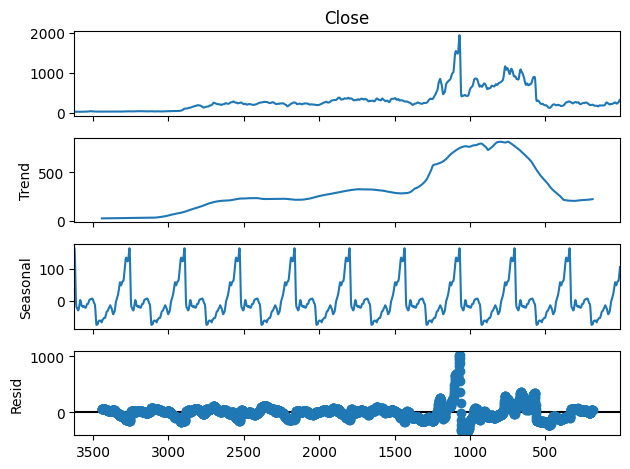

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal Decomposition
decomposition = seasonal_decompose(df['Close'], model='additive', period=365)  # Use period=365 for yearly seasonality

# Plot decomposition
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

###**Observation**

Based on the graphs above, **the trend shows a steady increase over time, with significant rise and then a gradual decline.** Towards the end of the series, there seems to be a decline or stabilization to certain values.

The seasonal component displays a clear periodic pattern. The peaks and troughs are regularly spaced, which indicates that **the stock exhibits some seasonality**. Finally, the periodicity of the seasonality suggests regular annual cycles.

**The residuals are mostly centered around zero**, indicating that the decomposition effectively captured most of the variability in the trend and seasonality.

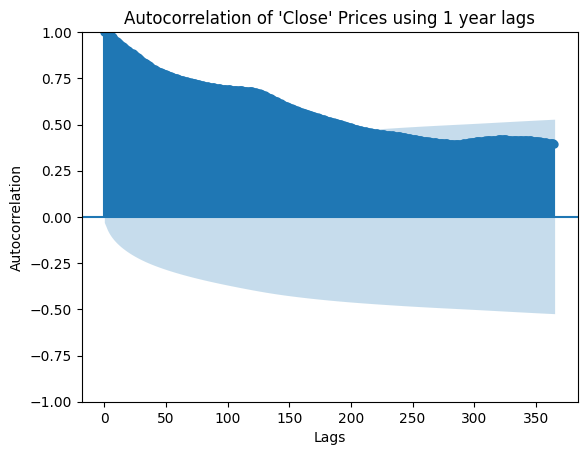

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Create ACF plot to find correlation between closing prices for interval of 1 year
plot_acf(df['Close'], lags=365)
plt.title("Autocorrelation of 'Close' Prices using 1 year lags")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

### **Observation**
We observe that the lagged features (daily closing prices) have a strong short-term correlation and there is no periodic trends such as weekly seasonability. Therfore, the lagged daily features will retain the fine-grained details that help capture these dependencies more accurately. With high ACF, sudden changes or trends in the daily prices (like upward or downward trends) are likely to carry forward. **Daily lagged values would capture these shifts more directly than weekly values, which tend to smooth over such changes, potentially missing short-term predictive information.**

#**Question A: Training, Validation and Testing of Linear Regression Model**


Model Parameters for N=1:
Bias: 0.5884972000161497
Weight for close_t-1: 0.9987855975608418
Model Equation:
Close_t = 0.5884972000161497 + (0.9987855975608418) * close_t-1

Model Parameters for N=2:
Bias: 1.3035024473763315
Weight for close_t-1: 1.9674291080419974
Weight for close_t-2: -0.9699704604851086
Model Equation:
Close_t = 1.3035024473763315 + (1.9674291080419974) * close_t-1 + (-0.9699704604851086) * close_t-2

Model Parameters for N=3:
Bias: 0.05357558541174967
Weight for close_t-1: 2.894542121246755
Weight for close_t-2: -2.850616242098919
Weight for close_t-3: 0.955966261219916
Model Equation:
Close_t = 0.05357558541174967 + (2.894542121246755) * close_t-1 + (-2.850616242098919) * close_t-2 + (0.955966261219916) * close_t-3

Model Parameters for N=4:
Bias: 0.11070411297680494
Weight for close_t-1: 3.7704961069681713
Weight for close_t-2: -5.462770911810306
Weight for close_t-3: 3.6084946476107733
Weight for close_t-4: -0.9164351532047936
Model Equation:
Close_t = 0.1107041

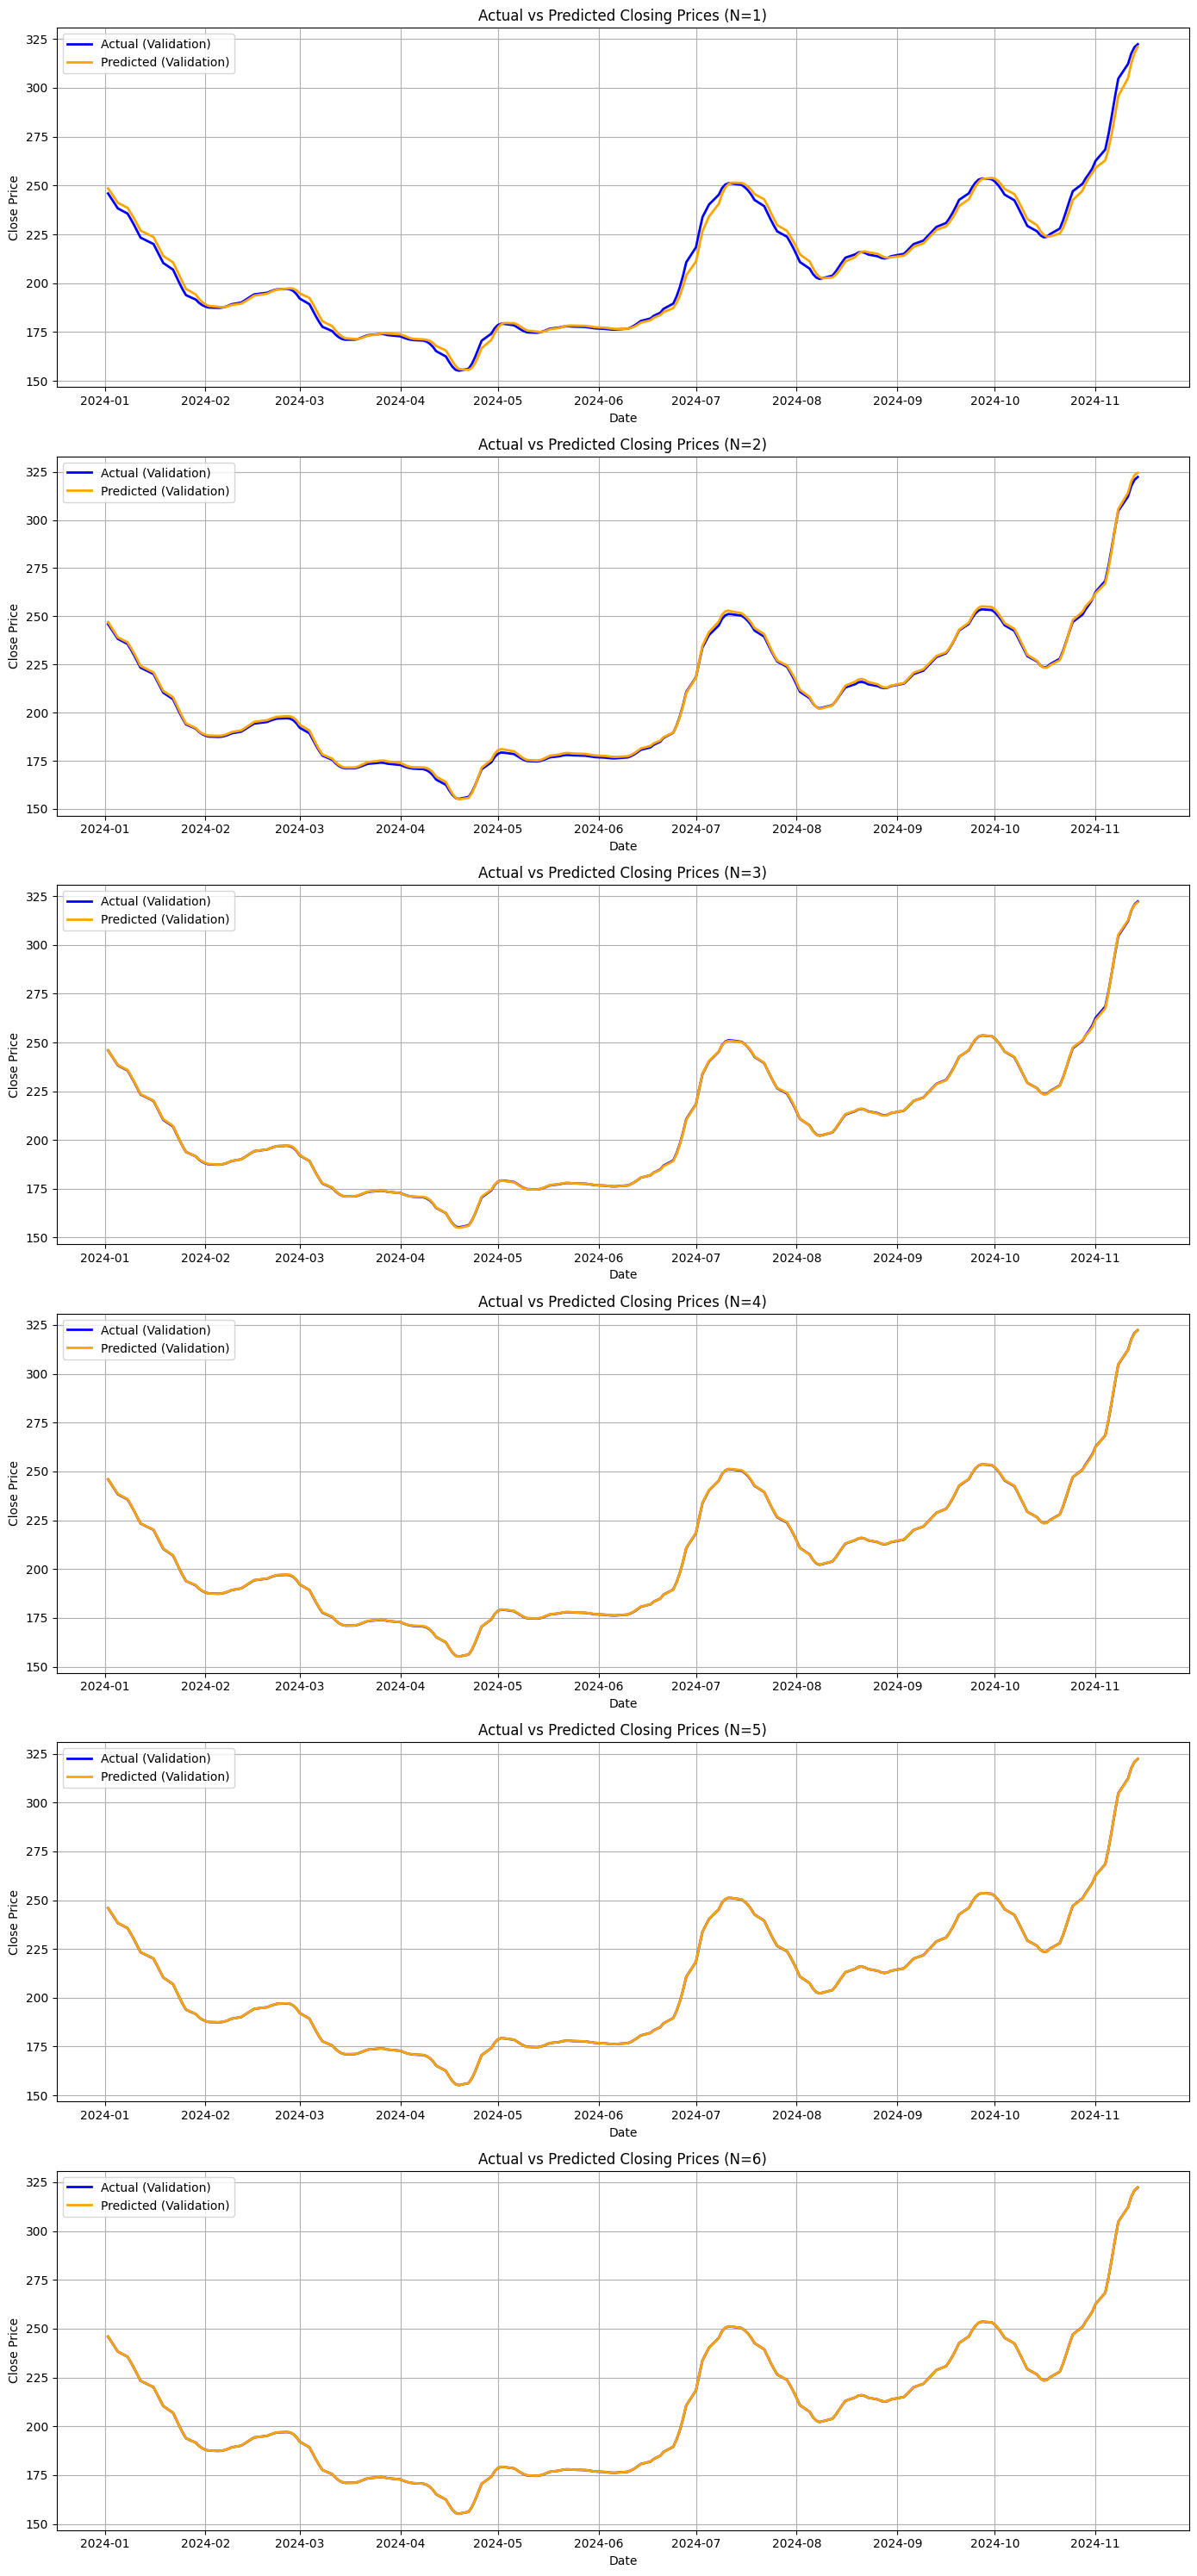

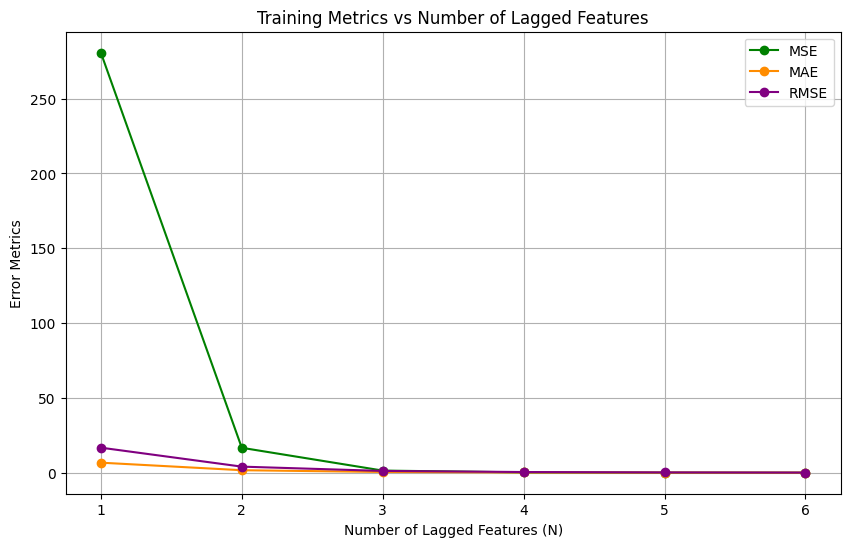

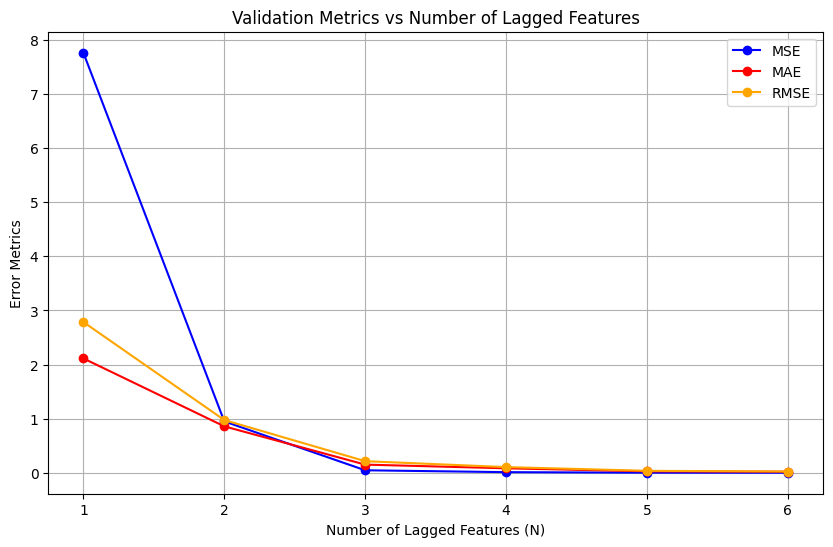

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a function that trains and evaluates the model for different amounts
# of lagged features and different DataFrames
def linear_regression_model(N, data):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training set and validation set
    train_data = data[data['Date'] < '2024-01-01']  # Use previous years for training
    validation_data = data[data['Date'] >= '2024-01-01']  # Use year 2024 for validation

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    # Create and fit the Linear Regression model using the training set
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions using the training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Evaluate metrics for training set
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mse = mean_squared_error(y_train, y_train_pred)

    # Evaluate metrics for validation set
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mse = mean_squared_error(y_val, y_val_pred)

    # Get model parameters (weights and bias)
    weights = model.coef_
    bias = model.intercept_

    return (train_mae, train_rmse, train_mse, val_mae, val_rmse, val_mse,
            y_train, y_train_pred, y_val, y_val_pred, validation_data['Date'], weights, bias)


# Plot the actual and predicted 'close' prices for the different values of lagged features
num_tests = 6  # Testing from N = 1 to 6
fig, axes = plt.subplots(num_tests, 1, figsize=(14, 5 * num_tests))
results = []

for idx, N in enumerate(range(1, num_tests + 1)):
    (train_mae, train_rmse, train_mse, val_mae, val_rmse, val_mse,
     y_train, y_train_pred, y_val, y_val_pred, dates, weights, bias) = linear_regression_model(N, df)  # Call the function here

    results.append((N, train_mae, train_rmse, train_mse, val_mae, val_rmse, val_mse))

    # Plot validation set actual vs predicted
    axes[idx].plot(dates, y_val, label='Actual (Validation)', color='blue', linewidth=2)
    axes[idx].plot(dates, y_val_pred, label='Predicted (Validation)', color='orange', linewidth=2)
    axes[idx].set_title(f'Actual vs Predicted Closing Prices (N={N})')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Close Price')
    axes[idx].legend()
    axes[idx].grid(True)

    # Print the model parameters and training metrics
    print(f"\nModel Parameters for N={N}:")
    print(f"Bias: {bias}")
    equation = f"Close_t = {bias}"
    for i, coef in enumerate(weights):
        equation += f" + ({coef}) * close_t-{i+1}"
        print(f"Weight for close_t-{i+1}: {coef}")
    print("Model Equation:")
    print(equation)

# Create a DataFrame for results
results_df = pd.DataFrame(results, columns=['N',
                                            'Train MAE', 'Train RMSE', 'Train MSE',
                                            'Val MAE', 'Val RMSE', 'Val MSE'])
print('\nMetrics')
print(results_df)

plt.tight_layout()
plt.show()

# Plot Training Metrics vs Number of Lagged Features
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_tests + 1), results_df['Train MSE'], marker='o', linestyle='-', color='green', label='MSE')
plt.plot(range(1, num_tests + 1), results_df['Train MAE'], marker='o', linestyle='-', color='darkorange', label='MAE')
plt.plot(range(1, num_tests + 1), results_df['Train RMSE'], marker='o', linestyle='-', color='purple', label='RMSE')

plt.title('Training Metrics vs Number of Lagged Features')
plt.xlabel('Number of Lagged Features (N)')
plt.ylabel('Error Metrics')
plt.xticks(range(1, num_tests + 1))
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Metrics vs Number of Lagged Features
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_tests + 1), results_df['Val MSE'], marker='o', linestyle='-', color='blue', label='MSE')
plt.plot(range(1, num_tests + 1), results_df['Val MAE'], marker='o', linestyle='-', color='red', label='MAE')
plt.plot(range(1, num_tests + 1), results_df['Val RMSE'], marker='o', linestyle='-', color='orange', label='RMSE')

plt.title('Validation Metrics vs Number of Lagged Features')
plt.xlabel('Number of Lagged Features (N)')
plt.ylabel('Error Metrics')
plt.xticks(range(1, num_tests + 1))
plt.legend()
plt.grid(True)
plt.show()

###**Observation**
We can observe that there is a significant drop in all Error Metrics when moving from N=1 to N=2. This suggests that having at least two lagged features improves the model's predictive power substantially. After N=3 the Error Metrics begin to stabilize, showing minimal improvement as N increases. This indicates that adding more lagged features beyond 3-4 doesn't contribute much additional predictive power.This means that the optimal amount of lagged features is 3-4 and with these the model can be trained really efficiently. The usage of more lagged features (probably 5-6 or even more) could lead to overfitting. **In general, we can see that indeed the Linear Regression Model performs really well on the validation dataset, since the data show a stable and flat trend.**

So, we will use this version of the Linear Regression Model with 3 lagged features in order to predict the TSLA stock closing prices from 2024-11-15 and onwards.

In [14]:
# Function to predict the close price for the next day
def predict_next_day_close_price(df, weights, bias, N):
    # Get the lagged features
    lagged_features = [f'close_t-{i}' for i in range(1, N + 1)]

    # Initialize the data for prediction using the last row of lagged features
    prediction_data = df[lagged_features].iloc[-1].values  # Extract last known lagged features

    # Calculate the predicted close price for the next day
    predicted_close = np.dot(prediction_data, weights) + bias

    return predicted_close

# Train the model with the best value of lagged features, which is N=3
N = 3
_, _, _, _, _, _, _, _, _, _, _, weights, bias = linear_regression_model(N, df)

# Predict the close price for the next day, which is 2024-11-15
start_date = '2024-11-15'
num_days = 1
next_day_prediction = predict_next_day_close_price(df, weights, bias, N)
print(f"Predicted close price for {start_date}: {next_day_prediction:.2f} $\n")

Predicted close price for 2024-11-15: 321.92 $



###**Real TSLA stock closing price for 15/11/2024**

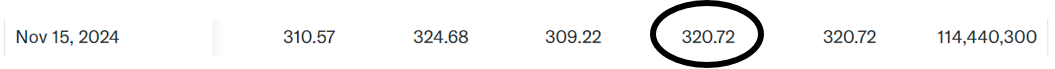

##**Conclusion**
We conclude that in terms of the **Linear Regression Model** the usage of **3 previous daily closing prices** as features works accurately enough for short-term predictions of brand new data, yet it might fail to generalize well for long-term data.

For Question B we will be also using the daily closing prices as lagged features.

#**Question B: Training, Validation and Testing of Polynomial Regression Model**

In general, a linear model assumes a consistent rate of change, which may not capture the complexities of TSLA price dynamics accurately. A polynomial model on the other hand, can capture these non-linear relationships by allowing the model to adjust more flexibly to changes in the trend. So we expect that the Polynomial Regression Model can achieve more accurate predictions if we find a moderate degree.

##**Using L1-Normalization**


Metrics for Polynomial Degree 1:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE   Val MSE
0  1   5.458498   14.579032  212.548171  2.112515  2.786529  7.764743
1  2   1.439342    3.755239   14.101816  0.748644  0.862437  0.743798
2  3   1.649281    4.308430   18.562572  0.849938  0.989789  0.979683
3  4   1.465325    3.831011   14.676647  0.756464  0.873802  0.763530
4  5   1.221996    3.167937   10.035826  0.607222  0.711695  0.506509
5  6   1.201594    3.028279    9.170476  0.534370  0.660022  0.435629
6  7   1.322682    3.294110   10.851161  0.550047  0.700257  0.490360
7  8   1.451926    3.611564   13.043394  0.594134  0.757979  0.574532


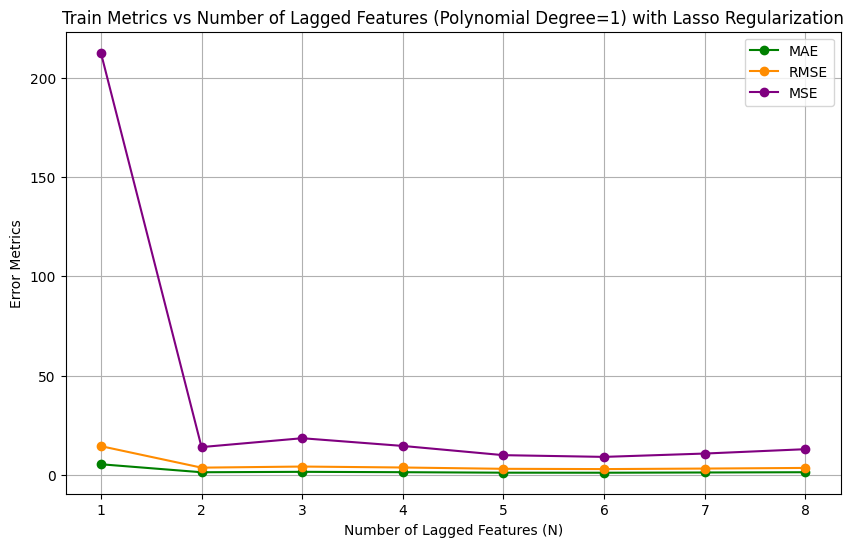

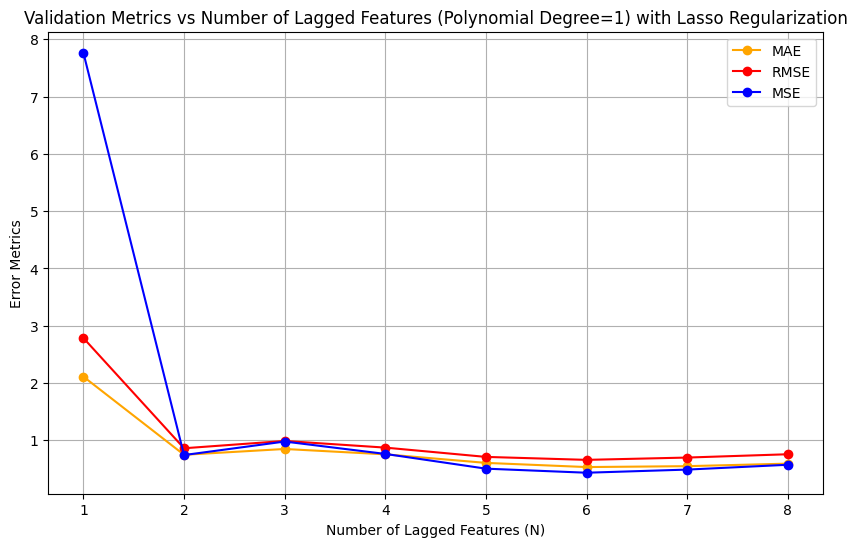


Metrics for Polynomial Degree 2:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE   Val MSE
0  1   5.521911   14.705411  216.249115  2.091135  2.791801  7.794153
1  2   1.812319    3.144107    9.885410  1.215808  1.573172  2.474871
2  3   2.091750    3.774376   14.245912  1.311323  1.676234  2.809761
3  4   1.650028    2.949878    8.701780  1.012081  1.310086  1.716325
4  5   1.270617    2.195596    4.820640  0.766742  1.020465  1.041349
5  6   1.275287    2.193110    4.809732  0.749558  0.990389  0.980871
6  7   1.370628    2.347354    5.510069  0.784867  1.029656  1.060191
7  8   1.460302    2.496434    6.232185  0.829830  1.083156  1.173227


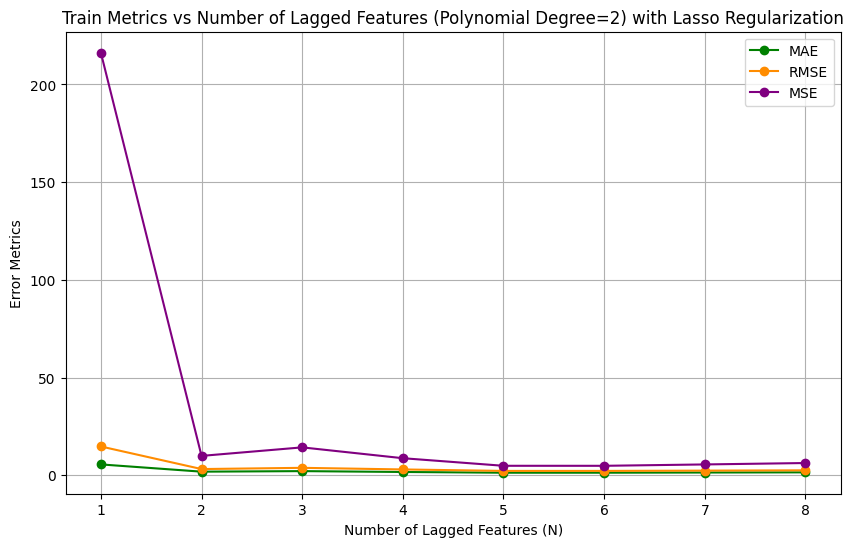

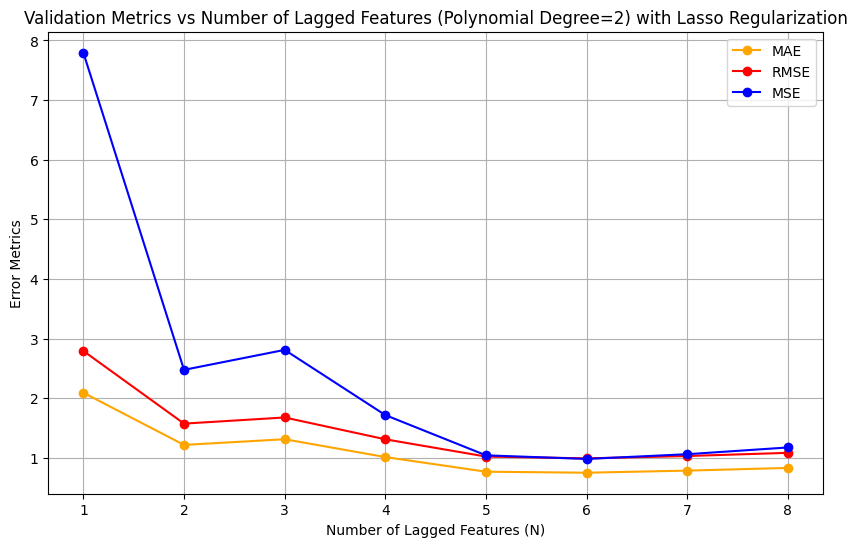


Metrics for Polynomial Degree 3:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE   Val MSE
0  1   5.626184   14.842569  220.301858  2.115622  2.800938  7.845255
1  2   1.931624    3.299482   10.886583  1.227633  1.580908  2.499269
2  3   1.952701    3.375176   11.391814  1.193227  1.506065  2.268230
3  4   1.569353    2.662207    7.087348  0.998929  1.269194  1.610854
4  5   1.445134    2.429091    5.900485  0.897386  1.177949  1.387564
5  6   1.485899    2.451358    6.009155  0.898673  1.185638  1.405738
6  7   1.513211    2.485997    6.180181  0.901521  1.190743  1.417868
7  8   1.503506    2.465576    6.079067  0.901639  1.193983  1.425595


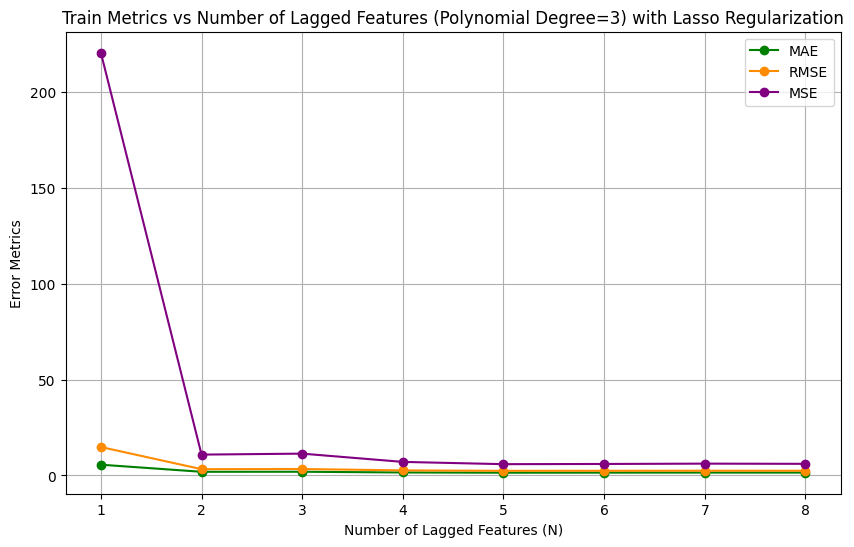

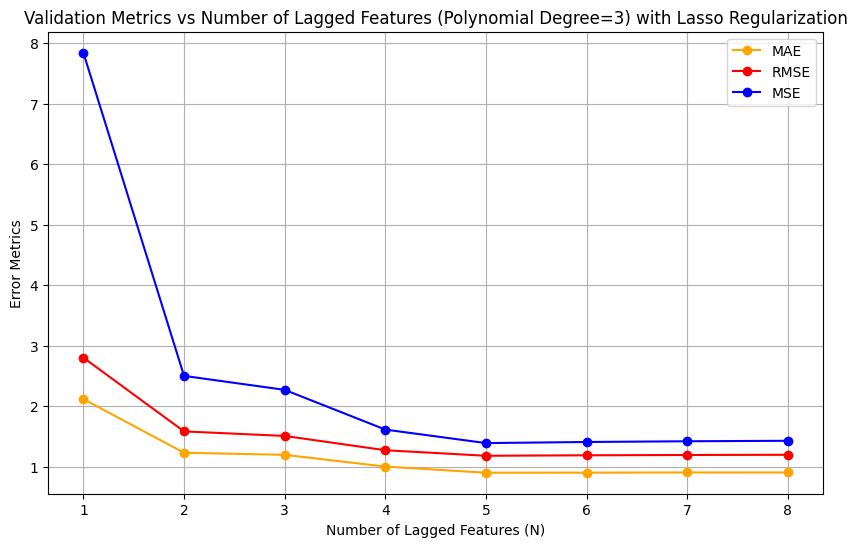

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e+05, tolerance: 1.672e+04
  model = cd_fast.enet_coordinate_descent(



Metrics for Polynomial Degree 4:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE   Val MSE
0  1   5.730877   14.986567  224.597190  2.088366  2.777824  7.716304
1  2   1.850173    3.062314    9.377769  1.198254  1.529912  2.340631
2  3   1.948289    3.283494   10.781332  1.248295  1.548214  2.396968
3  4   1.677709    2.815717    7.928261  1.021055  1.351844  1.827483
4  5   1.637644    2.694390    7.259737  1.070465  1.382019  1.909978
5  6   1.546655    2.492135    6.210738  1.006083  1.311184  1.719204
6  7   1.544969    2.479017    6.145527  0.977519  1.289502  1.662815
7  8   1.512545    2.425709    5.884066  0.967122  1.281410  1.642011


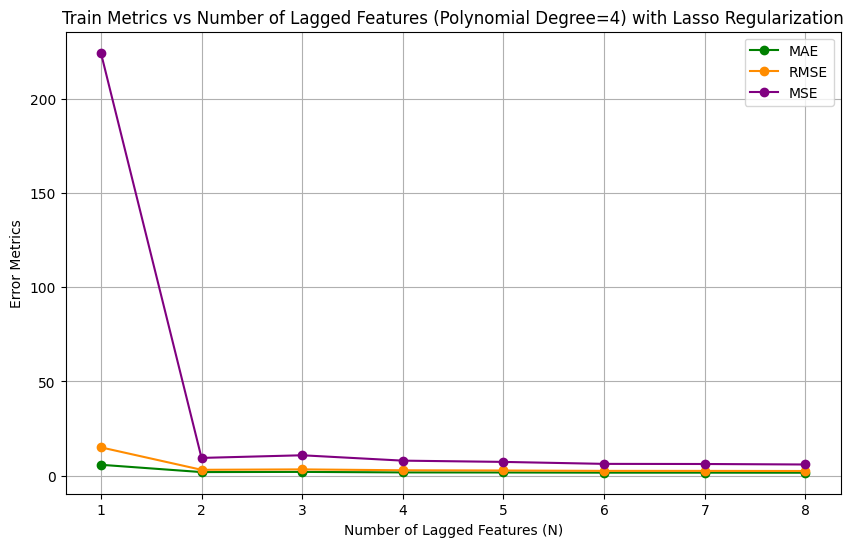

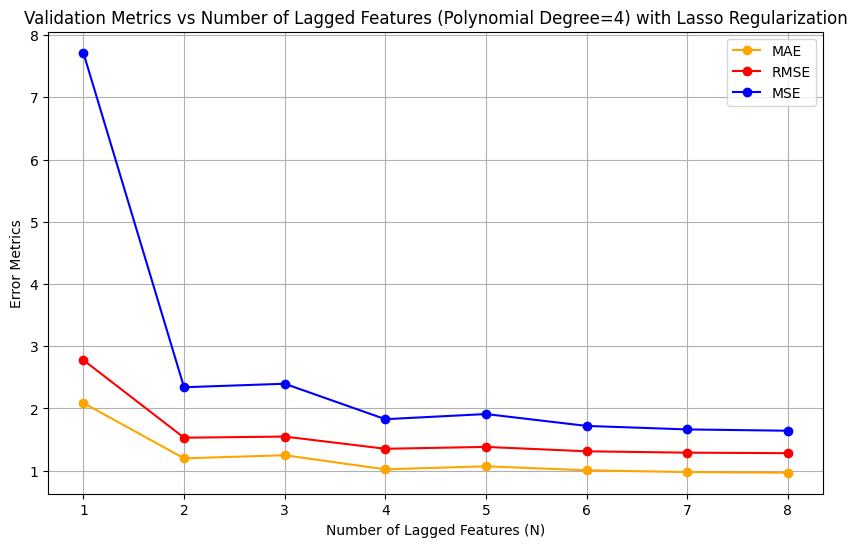

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e+05, tolerance: 1.648e+04
  model = cd_fast.enet_coordinate_descent(



Metrics for Polynomial Degree 5:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE   Val MSE
0  1   5.811971   15.137406  229.141055  2.088721  2.786807  7.766293
1  2   1.874031    3.067611    9.410236  1.176065  1.542822  2.380301
2  3   1.934658    3.212345   10.319161  1.130846  1.486841  2.210696
3  4   1.803781    3.010727    9.064479  1.155027  1.490767  2.222386
4  5   1.649752    2.688470    7.227871  1.089714  1.409410  1.986438
5  6   1.582456    2.517246    6.336529  1.016980  1.333573  1.778418
6  7   1.544721    2.451138    6.008078  0.978057  1.297197  1.682721
7  8   1.508435    2.389275    5.708637  0.967703  1.280064  1.638564


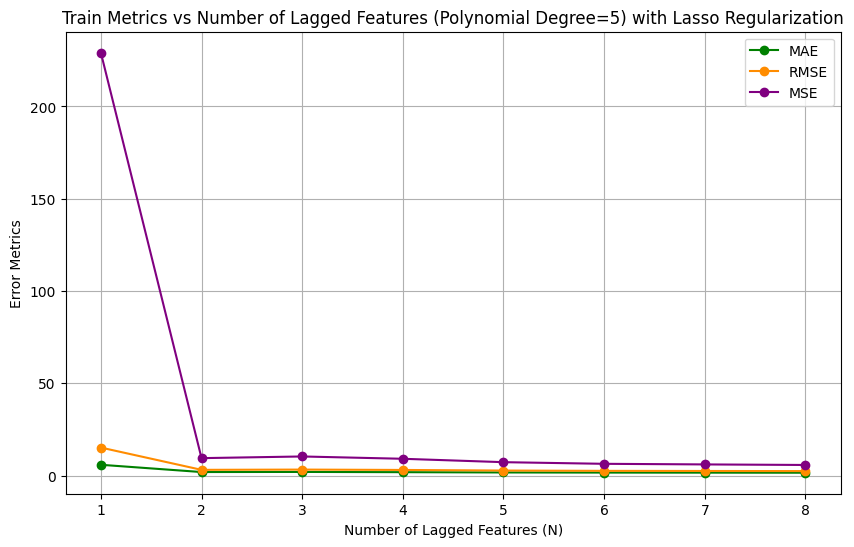

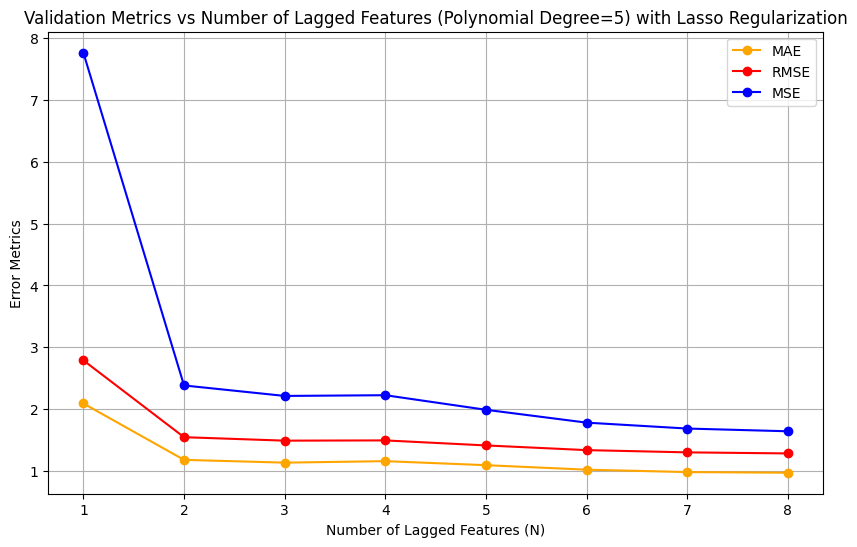

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e+05, tolerance: 1.630e+04
  model = cd_fast.enet_coordinate_descent(



Metrics for Polynomial Degree 6:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE   Val MSE
0  1   5.897617   15.293457  233.889820  2.088510  2.788145  7.773755
1  2   1.969191    3.246176   10.537659  1.201764  1.592596  2.536361
2  3   1.969036    3.245187   10.531240  1.163687  1.516935  2.301091
3  4   1.845820    3.089867    9.547276  1.185123  1.521203  2.314059
4  5   1.669554    2.719150    7.393774  1.067036  1.394844  1.945589
5  6   1.588836    2.514904    6.324740  0.998498  1.322922  1.750123
6  7   1.506019    2.367166    5.603474  0.956503  1.269478  1.611574
7  8   1.577934    2.476469    6.132901  1.005285  1.321964  1.747590


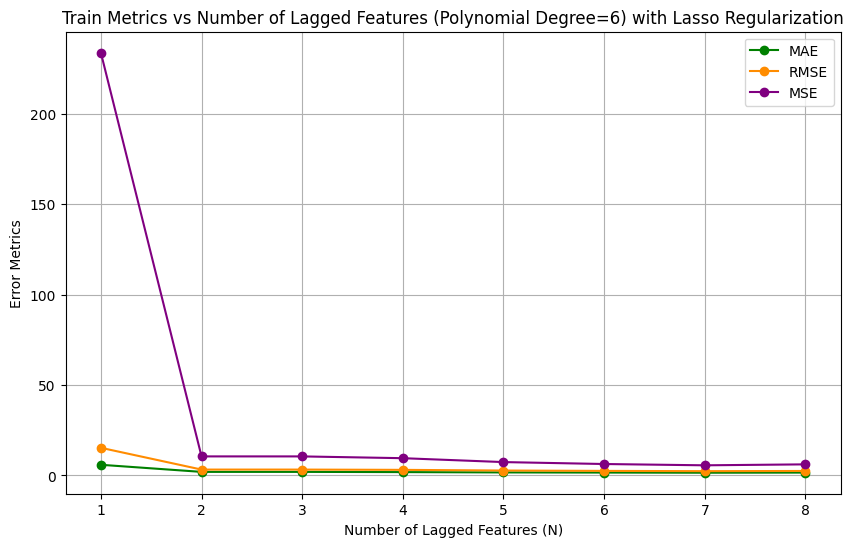

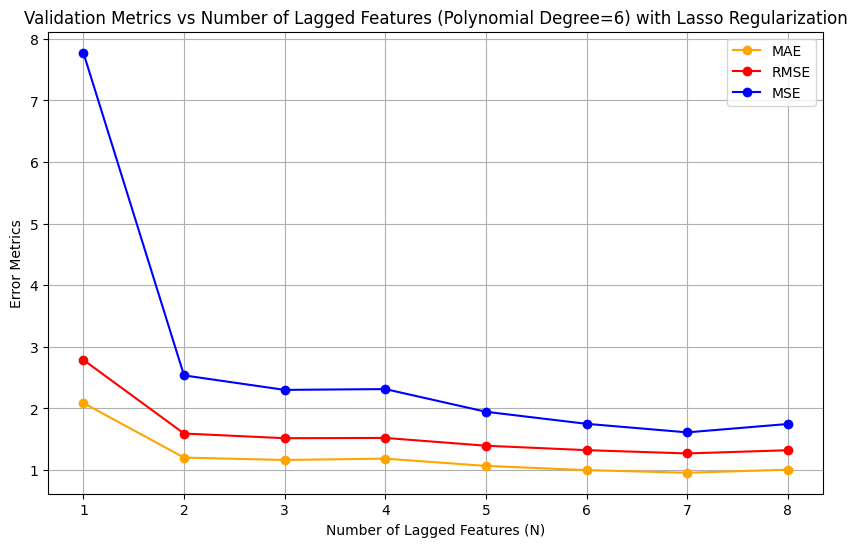

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e+05, tolerance: 1.617e+04
  model = cd_fast.enet_coordinate_descent(



Metrics for Polynomial Degree 7:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE   Val MSE
0  1   5.988583   15.454055  238.827812  2.091705  2.794605  7.809816
1  2   2.061799    3.439341   11.829068  1.261075  1.651167  2.726353
2  3   2.013808    3.312374   10.971824  1.206560  1.551388  2.406806
3  4   1.857653    3.116880    9.714940  1.150602  1.492598  2.227848
4  5   1.723522    2.804116    7.863069  1.068263  1.407905  1.982196
5  6   1.533193    2.397140    5.746281  0.962828  1.279956  1.638287
6  7   1.554128    2.413334    5.824181  0.986257  1.300600  1.691561
7  8   1.655643    2.588478    6.700219  1.055474  1.377149  1.896540


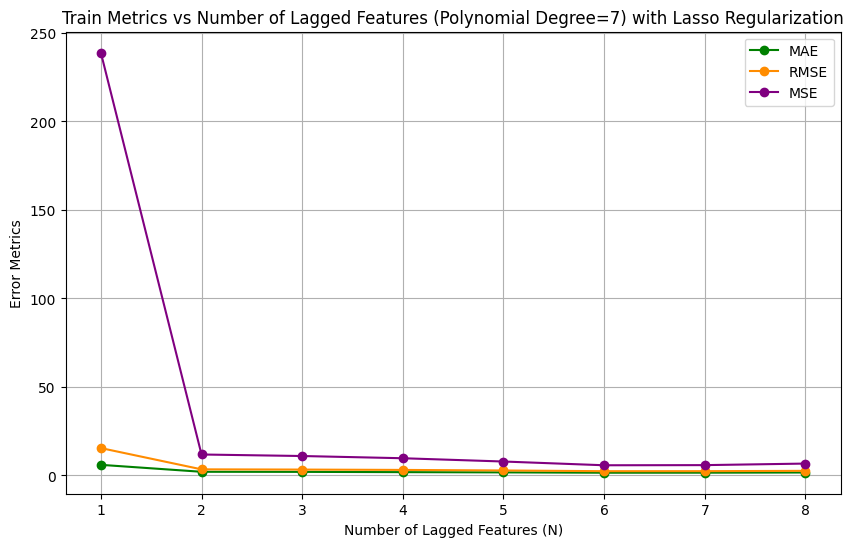

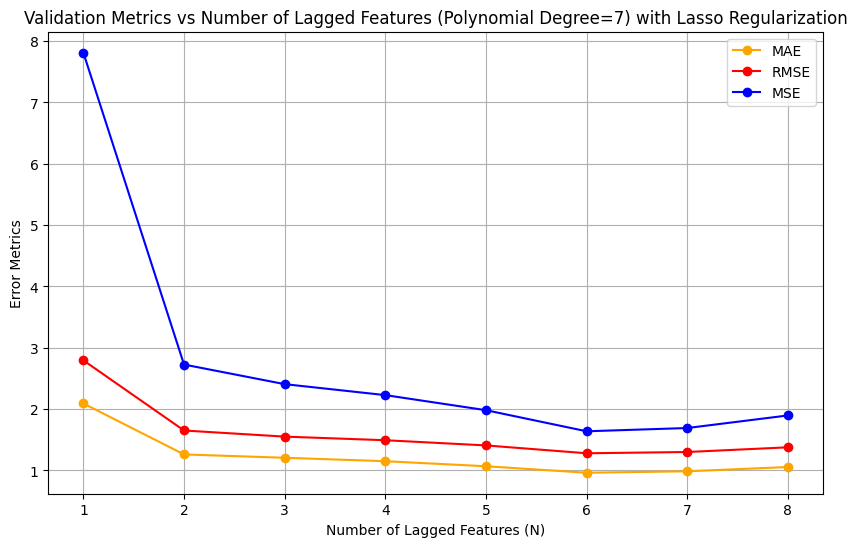

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e+05, tolerance: 1.610e+04
  model = cd_fast.enet_coordinate_descent(



Metrics for Polynomial Degree 8:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE    Val MSE
0  1   7.760437   16.334011  266.799905  6.674580  7.597165  57.716914
1  2   2.095378    3.514089   12.348823  1.299592  1.682179   2.829725
2  3   2.019464    3.336889   11.134825  1.198995  1.549215   2.400068
3  4   1.886052    3.174307   10.076226  1.148158  1.498113   2.244342
4  5   1.724541    2.792986    7.800770  1.054614  1.399904   1.959730
5  6   1.540978    2.378787    5.658629  0.974633  1.288410   1.660001
6  7   1.627531    2.510759    6.303911  1.037553  1.352246   1.828570
7  8   1.684366    2.626149    6.896660  1.074633  1.397192   1.952144


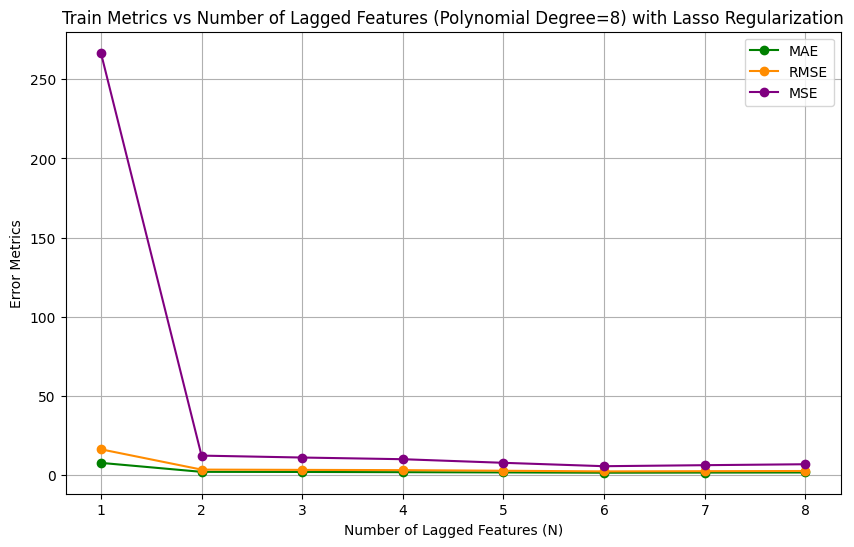

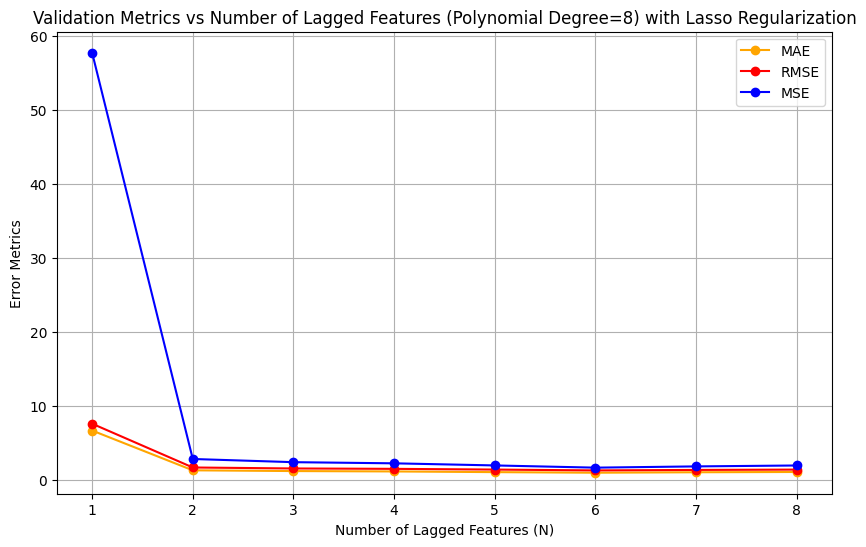

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Create a function that trains and evaluates polynomial regression with Lasso for different lags (N)
def polynomial_regression_model_L1(degree, N, data):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training set and validation set
    train_data = data[data['Date'] < '2024-01-01']  # Use previous years for training
    validation_data = data[data['Date'] >= '2024-01-01']  # Use year 2024 for validation

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Define the parameter grid for GridSearchCV
    param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}  # Testing for different alpha values

    # Initialize GridSearchCV with Lasso model
    lasso = Lasso(max_iter=10000)

    # Perform grid search with cross-validation for selecting the best alpha value
    grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Extract the best alpha from the grid search results
    alpha = grid_search.best_params_['alpha']

    # Create and fit Lasso regression model using the training set and optimal alpha
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train_poly, y_train)

    # Make predictions for both training and validation sets
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)

    # Evaluate the model metrics for training set
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mse = mean_squared_error(y_train, y_train_pred)

    # Evaluate the model metrics for validation set
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mse = mean_squared_error(y_val, y_val_pred)

    # Extract model parameters
    weights = model.coef_
    bias = model.intercept_

    return train_mae, train_rmse, train_mse, val_mae, val_rmse, val_mse, y_train, y_train_pred, y_val, y_val_pred, validation_data['Date'], weights, bias

# Define parameters
num_tests = 8  # Testing for lags N = 1 to 8
max_degree = 8  # Testing for polynomial degree = 1 to 8

# Initialize figure for metrics comparison for each degree
all_results = []  # Collect results for all degrees

for degree in range(1, max_degree + 1):
    results = []

    for N in range(1, num_tests + 1):
        # Get results for training and validation metrics
        train_mae, train_rmse, train_mse, val_mae, val_rmse, val_mse, y_train, y_train_pred, y_val, y_val_pred, dates, _, _ = polynomial_regression_model_L1(degree, N, df)

        # Append results for current degree and lag N
        results.append((N, train_mae, train_rmse, train_mse, val_mae, val_rmse, val_mse))

    # DataFrame for results
    results_df = pd.DataFrame(results, columns=['N',
                                            'Train MAE', 'Train RMSE', 'Train MSE',
                                            'Val MAE', 'Val RMSE', 'Val MSE'])
    all_results.append((degree, results_df))

    # Print metrics for this degree
    print(f"\nMetrics for Polynomial Degree {degree}:")
    print(results_df)

    # Plot training metrics
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['N'], results_df['Train MAE'], marker='o', linestyle='-', color='green', label='MAE')
    plt.plot(results_df['N'], results_df['Train RMSE'], marker='o', linestyle='-', color='darkorange', label='RMSE')
    plt.plot(results_df['N'], results_df['Train MSE'], marker='o', linestyle='-', color='purple', label='MSE')

    plt.title(f'Train Metrics vs Number of Lagged Features (Polynomial Degree={degree}) with Lasso Regularization')
    plt.xlabel('Number of Lagged Features (N)')
    plt.ylabel('Error Metrics')
    plt.xticks(range(1, num_tests + 1))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot validation metrics
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['N'], results_df['Val MAE'], marker='o', linestyle='-', color='orange', label='MAE')
    plt.plot(results_df['N'], results_df['Val RMSE'], marker='o', linestyle='-', color='red', label='RMSE')
    plt.plot(results_df['N'], results_df['Val MSE'], marker='o', linestyle='-', color='blue', label='MSE')

    plt.title(f'Validation Metrics vs Number of Lagged Features (Polynomial Degree={degree}) with Lasso Regularization')
    plt.xlabel('Number of Lagged Features (N)')
    plt.ylabel('Error Metrics')
    plt.xticks(range(1, num_tests + 1))
    plt.legend()
    plt.grid(True)
    plt.show()

##**Observation**

**The best trade-off between complexity and performance for the model emerges for a polynomial degree of 3–4 and a number of lagged features again between 3–4**, as observed in Linear Regression. Generally, except for the case where degree = 1, we see that for all different degree values, the error tends to stabilize at a certain value after using 4 lagged features. Therefore, using more features does not provide any additional improvement in the model's performance. However, unlike the Linear Model, where the error tends to approach zero, here we observe that the error stabilizes at a noticeably higher value (around 2).

**Thus, while the error remains within an acceptable range, indicating that the model has reached a good balance without requiring additional complexity, Lasso Regularization certainly seems to perform worse compared to the Linear Model.**

Additionally, concerning the polynomial degree, we observe that for degree = 2, the model is simple and efficient, but it may fall short in capturing complex nonlinear relationships. On the other hand, for degree = 5 and above, the complexity increases without significant improvement in performance, potentially leading to overfitting. **Therefore, for degree = 3 or 4, the most satisfactory balance is achieved, as the model can accurately capture more complex relationships in the data without causing an "explosion" in the number of polynomial coefficients.**

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to predict close prices for the new date
def predict_next_day_close_price(df, weights, bias, degree, N):
    # Get the lagged features
    lagged_features = [f'close_t-{i}' for i in range(1, N + 1)]

    # Create polynomial features object
    poly = PolynomialFeatures(degree=degree)

    # Initialize the data for prediction using the last row of lagged features
    prediction_data = df[lagged_features].iloc[-1].values  # Extract last known lagged features

    # Transform the lagged features into polynomial features
    prediction_data_poly = poly.fit_transform(prediction_data.reshape(1, -1))  # Reshape to 2D array

    # Calculate the predicted close price for the next day
    predicted_close = np.dot(prediction_data_poly, weights) + bias

    return predicted_close[0]

# Function that calculates the polynomial equation of the model
def print_polynomial_equation(weights, bias, degree, N):
    equation = f"Close_t = {bias}"

    # Create the polynomial terms dynamically based on N and degree
    feature_idx = 0
    for d in range(1, degree+1):  # Loop through degrees
        for i in range(N):  # Loop through lag values
            if d == 1:
                # Linear term (close_t-x)
                equation += f" + ({weights[feature_idx]}) * close_t-{i+1}"
            else:
                # Higher order terms (close_t-x^d)
                equation += f" + ({weights[feature_idx]}) * close_t-{i+1}^{d}"
            feature_idx += 1

    print(f"Polynomial Equation: {equation}\n")

# Train the model with the best value of lagged features, which is N=3 and best degree, which is 3
N = 3
degree = 3
_, _, _, _, _, _, _, _, _, _, _, weights, bias = polynomial_regression_model_L1(degree, N, df)
print_polynomial_equation(weights, bias, degree, N) # Print polynomial equation

# Predict the close price for the next day, which is 2024-11-15
next_date = '2024-11-15'
next_day_prediction = predict_next_day_close_price(df, weights, bias, degree, N)
print(f"Predicted close price for {start_date}: {next_day_prediction:.2f} $\n")

Polynomial Equation: Close_t = 3.0015269136335974 + (0.0) * close_t-1 + (1.2980066191979724) * close_t-2 + (-0.18636784999643352) * close_t-3 + (-0.1304114765870124) * close_t-1^2 + (0.00019471155672510883) * close_t-2^2 + (-5.25966641051802e-05) * close_t-3^2 + (-2.5991818616084295e-05) * close_t-1^3 + (-2.7616551676277555e-05) * close_t-2^3 + (-2.685740580748707e-05) * close_t-3^3

Predicted close price for 2024-11-15: 322.96 $



###**Real TSLA stock closing price for 15/11/2024**

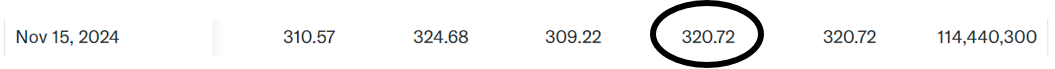

##**Using L2-Normalization**


Metrics for Polynomial Degree 1:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE   Val MSE
0  1   6.234635   15.891182  252.529656  2.105782  2.787231  7.768658
1  2   1.560425    3.876556   15.027688  0.799524  0.917804  0.842365
2  3   0.476526    1.138574    1.296351  0.149162  0.213427  0.045551
3  4   0.195137    0.456593    0.208477  0.078194  0.100618  0.010124
4  5   0.087631    0.211950    0.044923  0.026239  0.035663  0.001272
5  6   0.044579    0.105802    0.011194  0.018219  0.022462  0.000505


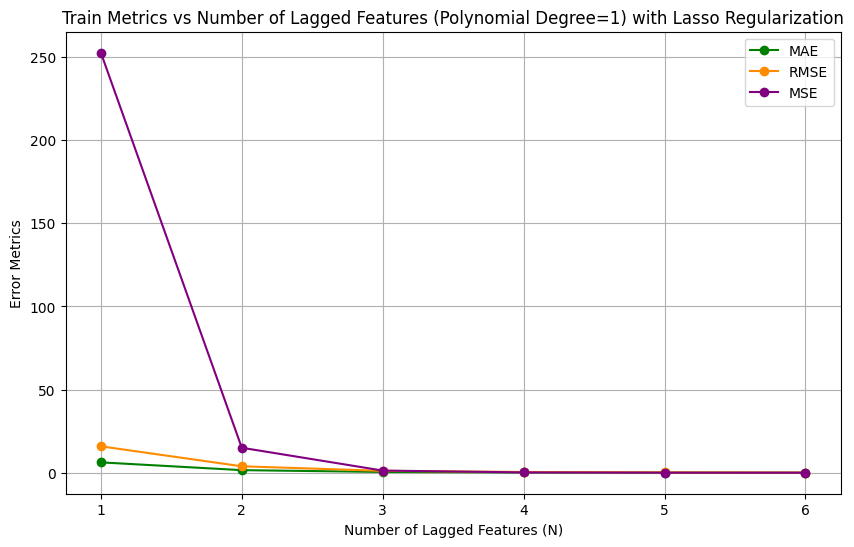

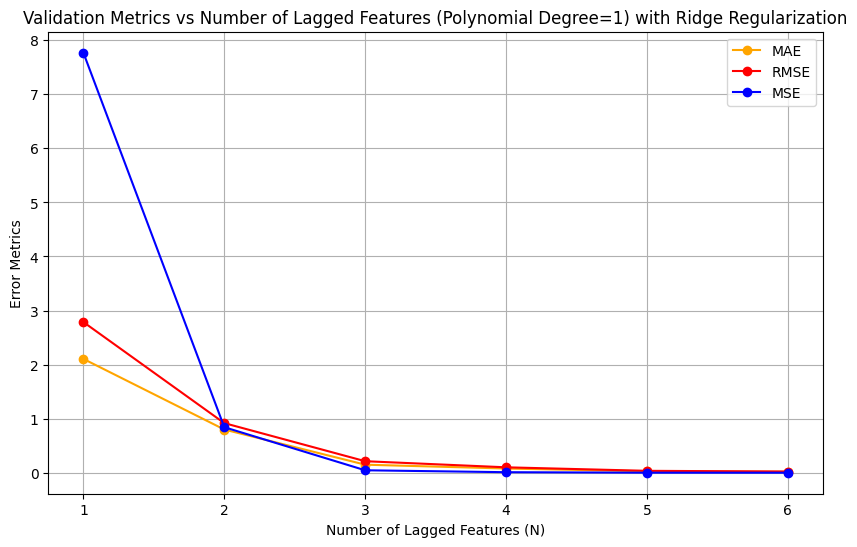

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.73234e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.84973e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.90611e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.36845e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Metrics for Polynomial Degree 2:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE   Val MSE
0  1   6.260235   15.979365  255.340112  2.112540  2.815184  7.925263
1  2   1.526025    2.783055    7.745395  0.814383  1.017819  1.035956
2  3   0.412972    0.701022    0.491432  0.169355  0.246470  0.060747
3  4   0.160880    0.261614    0.068442  0.067988  0.096861  0.009382
4  5   0.072785    0.112993    0.012767  0.031658  0.041062  0.001686
5  6   0.040521    0.062753    0.003938  0.022795  0.030708  0.000943


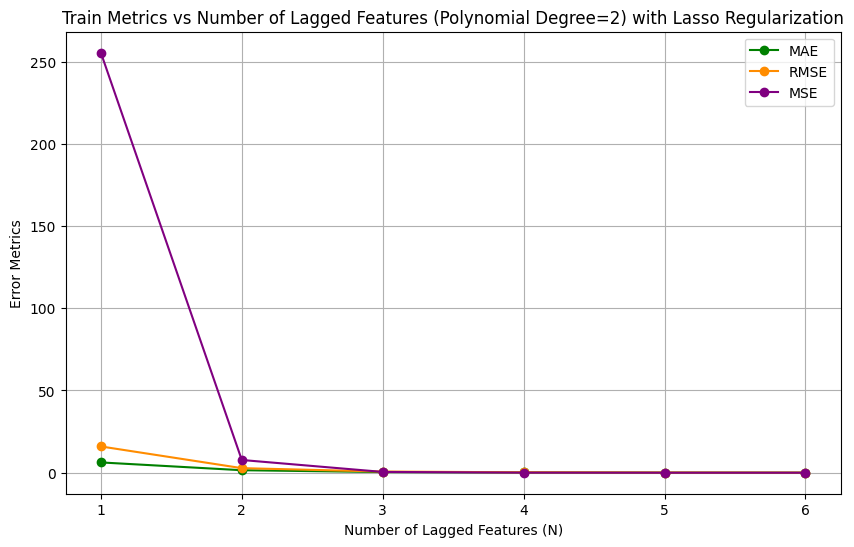

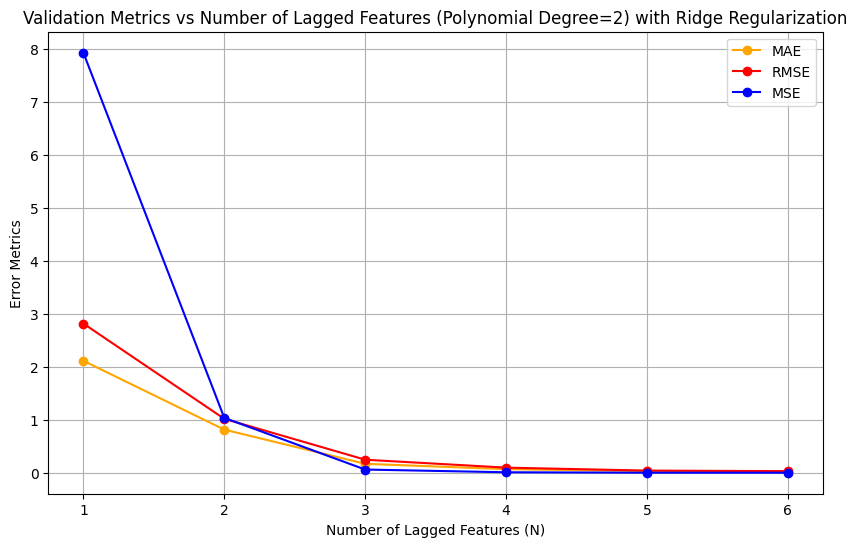

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.26453e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.17413e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.27316e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Metrics for Polynomial Degree 3:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE   Val MSE
0  1   6.329166   16.077680  258.491779  2.107666  2.804194  7.863506
1  2   1.389447    2.503241    6.266214  0.712569  0.864378  0.747149
2  3   0.387197    0.631444    0.398722  0.158456  0.232572  0.054090
3  4   0.148864    0.230428    0.053097  0.066579  0.094563  0.008942
4  5   0.062783    0.091749    0.008418  0.033386  0.046133  0.002128
5  6   0.035105    0.048806    0.002382  0.024218  0.032489  0.001056


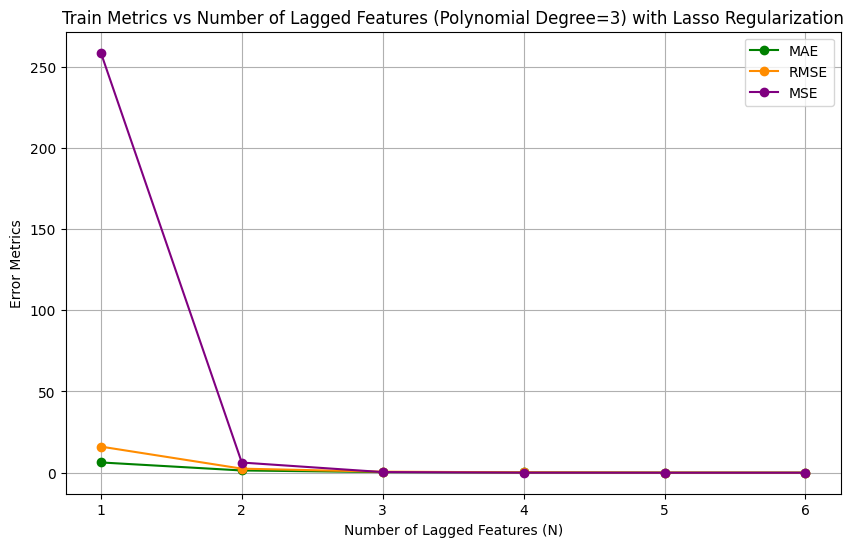

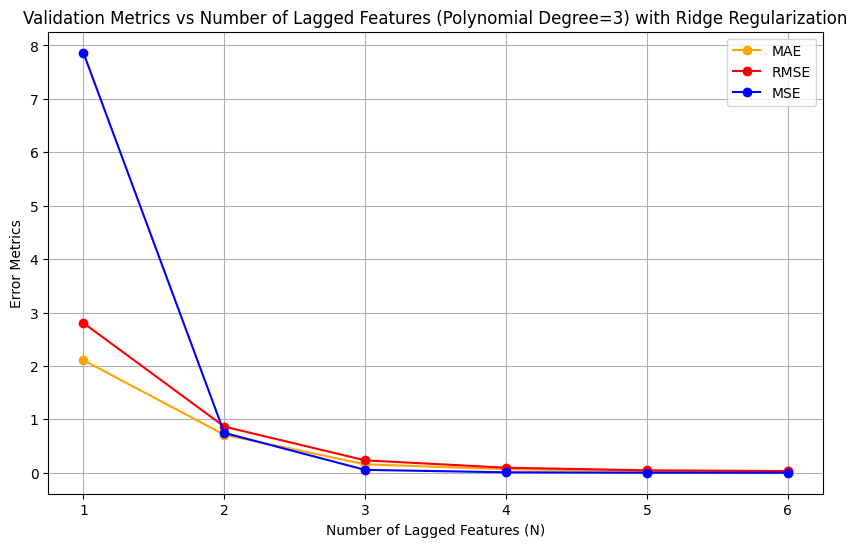

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.79015e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.64185e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Metrics for Polynomial Degree 4:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE   Val MSE
0  1   6.408598   16.181463  261.839750  2.093654  2.791880  7.794592
1  2   1.325286    2.160925    4.669599  0.672339  0.824584  0.679939
2  3   0.368830    0.591159    0.349468  0.170684  0.247718  0.061364
3  4   0.132797    0.196925    0.038780  0.063474  0.086698  0.007517
4  5   0.057467    0.080710    0.006514  0.036260  0.049638  0.002464
5  6   0.042765    0.065234    0.004256  0.030623  0.040573  0.001646


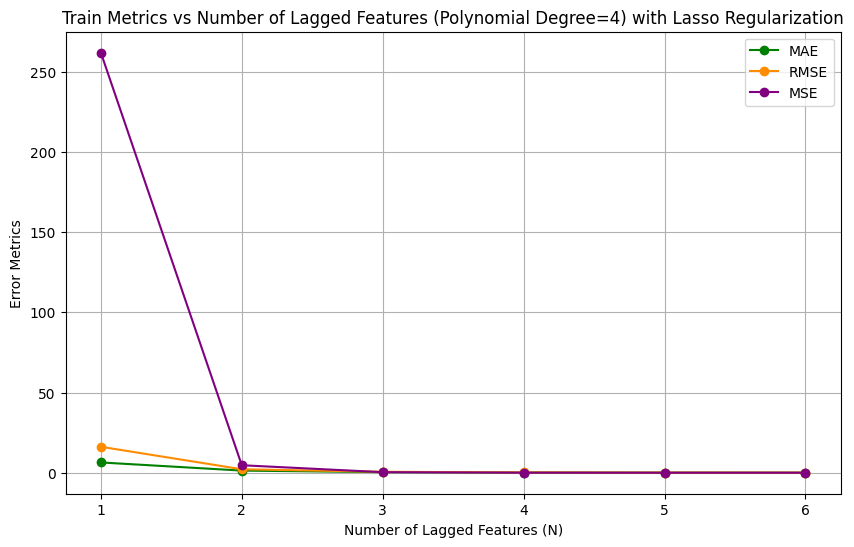

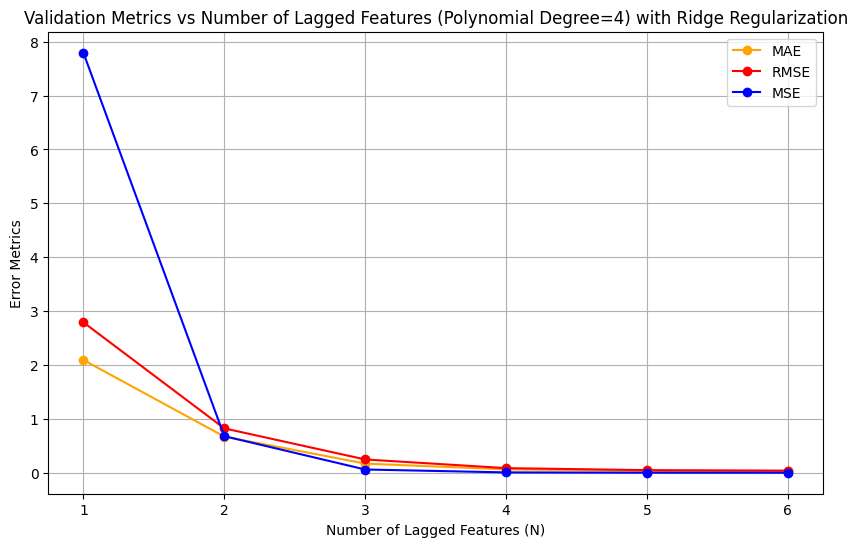

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.62766e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Metrics for Polynomial Degree 5:
   N  Train MAE  Train RMSE   Train MSE   Val MAE  Val RMSE    Val MSE
0  1   6.442437   16.289969  265.363087  2.094986  2.801820   7.850193
1  2   1.349094    2.184203    4.770741  0.890645  1.016637   1.033551
2  3   2.099653    3.833421   14.695114  0.782765  0.951554   0.905455
3  4   1.309824    2.133504    4.551839  1.754056  1.922258   3.695077
4  5   2.577479    3.894467   15.166872  2.402522  2.559820   6.552676
5  6  11.194063   17.863534  319.105863  6.408289  6.770885  45.844883


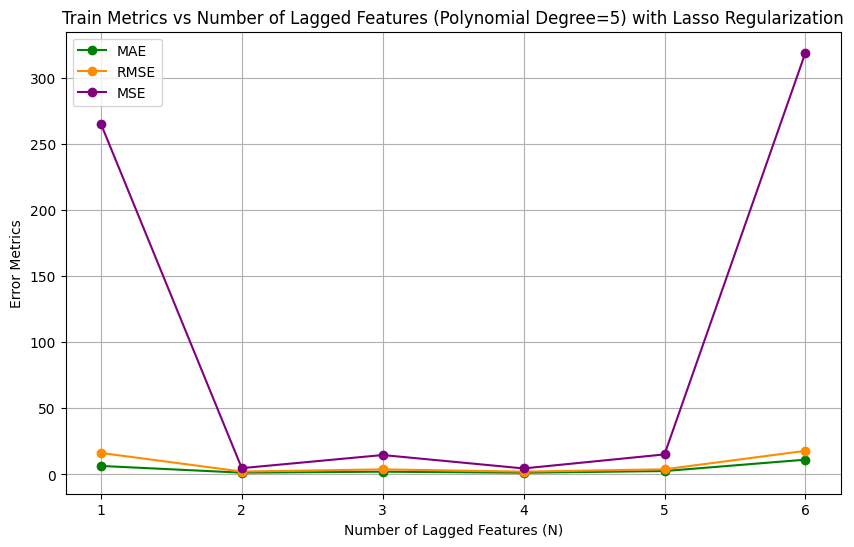

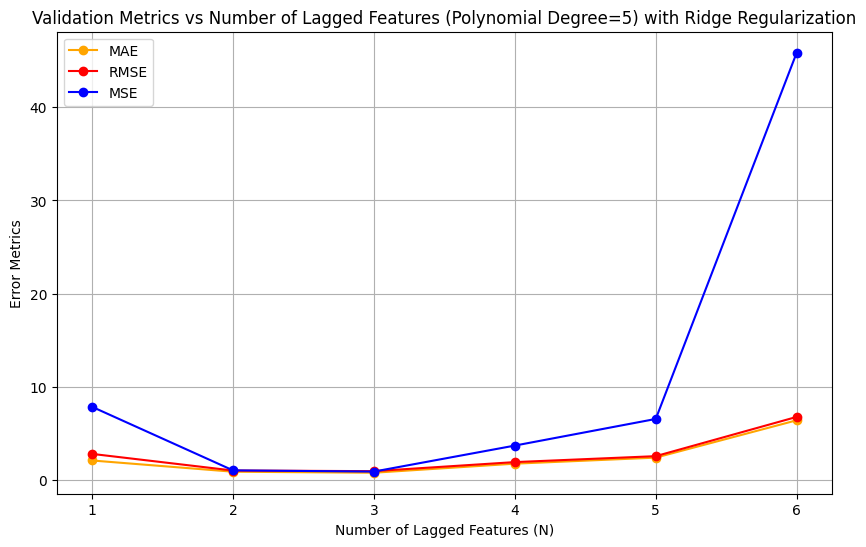

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.18639e-39): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Metrics for Polynomial Degree 6:
   N   Train MAE  Train RMSE     Train MSE     Val MAE    Val RMSE  \
0  1    6.508459   16.403462    269.073563    2.096434    2.805370   
1  2    2.595231    3.662571     13.414424    2.382813    2.966818   
2  3   13.791345   21.194682    449.214545    9.070573   10.492486   
3  4  103.995762  182.497124  33305.200210  114.849009  124.430545   
4  5   54.339608   89.756098   8056.157140   41.493195   43.132817   
5  6    5.251075    8.663372     75.054016    1.986787    2.462516   

        Val MSE  
0      7.870099  
1      8.802011  
2    110.092259  
3  15482.960591  
4   1860.439902  
5      6.063987  


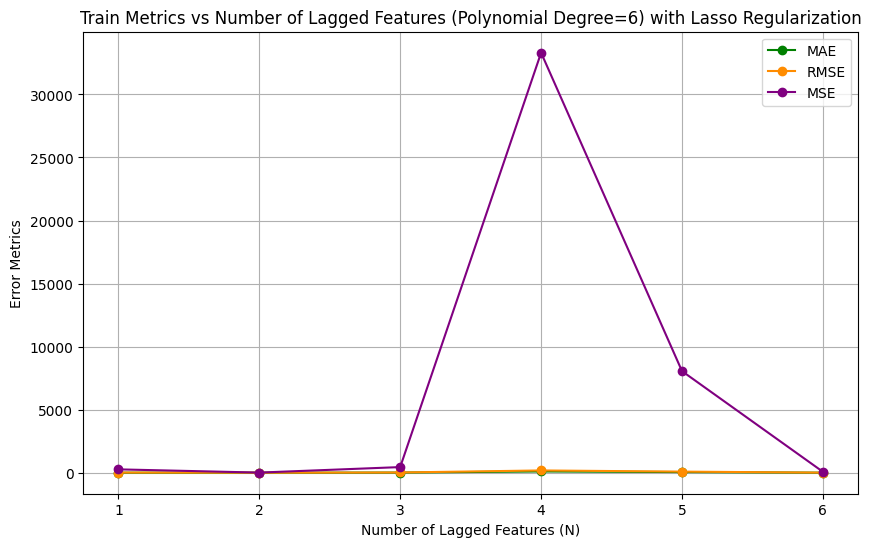

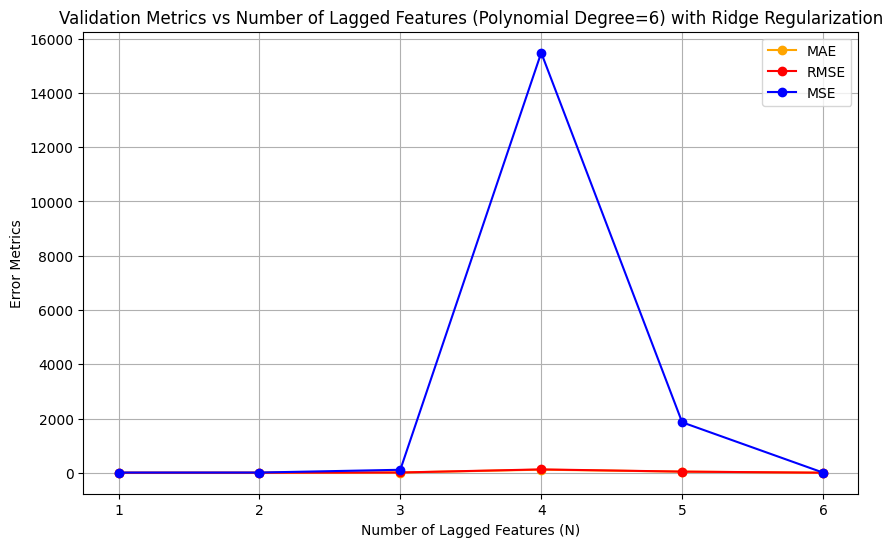

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a function that trains and evaluates polynomial regression with Ridge for different lags (N)
def polynomial_regression_model_L2(degree, N, data):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training set and validation set
    train_data = data[data['Date'] < '2024-01-01']  # Use previous years for training
    validation_data = data[data['Date'] >= '2024-01-01']  # Use year 2024 for validation

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Define the parameter grid for GridSearchCV
    param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}  # Testing for different alpha values

    # Initialize GridSearchCV with Ridge model
    ridge = Ridge(max_iter=10000)

    # Perform grid search with cross-validation for selecting the best alpha value
    grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Extract the best alpha from the grid search results
    alpha = grid_search.best_params_['alpha']
    #print(f"Best alpha value is: {alpha}")

    # Create and fit Ridge regression model using the training set and optimal alpha=0.01
    model = Ridge(alpha=alpha, max_iter=10000)
    model.fit(X_train_poly, y_train)

    # Make predictions for both training and validation sets
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)

    # Evaluate the model metrics for training set
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mse = mean_squared_error(y_train, y_train_pred)

    # Evaluate the model metrics for validation set
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mse = mean_squared_error(y_val, y_val_pred)

    # Extract model parameters
    weights = model.coef_
    bias = model.intercept_

    return train_mae, train_rmse, train_mse, val_mae, val_rmse, val_mse, y_train, y_train_pred, y_val, y_val_pred, validation_data['Date'], weights, bias

# Define parameters
num_tests = 6  # Testing for lags N = 1 to 6
max_degree = 6  # Testing for degree = 1 to 6

# Initialize figure for metrics comparison for each degree
all_results = []  # Collect results for all degrees

for degree in range(1, max_degree + 1):
    results = []

    for N in range(1, num_tests + 1):
        # Get results for training and validation metrics
        train_mae, train_rmse, train_mse, val_mae, val_rmse, val_mse, y_train, y_train_pred, y_val, y_val_pred, dates, _, _ = polynomial_regression_model_L2(degree, N, df)

        # Append results for current degree and lag N
        results.append((N, train_mae, train_rmse, train_mse, val_mae, val_rmse, val_mse))

    # DataFrame for results
    results_df = pd.DataFrame(results, columns=['N',
                                            'Train MAE', 'Train RMSE', 'Train MSE',
                                            'Val MAE', 'Val RMSE', 'Val MSE'])
    all_results.append((degree, results_df))

    # Print metrics for this degree
    print(f"\nMetrics for Polynomial Degree {degree}:")
    print(results_df)

    # Plot training metrics
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['N'], results_df['Train MAE'], marker='o', linestyle='-', color='green', label='MAE')
    plt.plot(results_df['N'], results_df['Train RMSE'], marker='o', linestyle='-', color='darkorange', label='RMSE')
    plt.plot(results_df['N'], results_df['Train MSE'], marker='o', linestyle='-', color='purple', label='MSE')

    plt.title(f'Train Metrics vs Number of Lagged Features (Polynomial Degree={degree}) with Lasso Regularization')
    plt.xlabel('Number of Lagged Features (N)')
    plt.ylabel('Error Metrics')
    plt.xticks(range(1, num_tests + 1))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot validation metrics
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['N'], results_df['Val MAE'], marker='o', linestyle='-', color='orange', label='MAE')
    plt.plot(results_df['N'], results_df['Val RMSE'], marker='o', linestyle='-', color='red', label='RMSE')
    plt.plot(results_df['N'], results_df['Val MSE'], marker='o', linestyle='-', color='blue', label='MSE')

    plt.title(f'Validation Metrics vs Number of Lagged Features (Polynomial Degree={degree}) with Ridge Regularization')
    plt.xlabel('Number of Lagged Features (N)')
    plt.ylabel('Error Metrics')
    plt.xticks(range(1, num_tests + 1))
    plt.legend()
    plt.grid(True)
    plt.show()

###**Observation**
**The best trade-off between complexity and performance for the model occurs for a polynomial degree of 4 and a number of lagged features between 3–4.** Overfitting becomes significantly more apparent when the polynomial degree exceeds 4, as the error "spikes" dramatically once the lagged features surpass 4, rather than stabilizing at a specific value.

Thus, in the case of Ridge regularization, excessively increasing the polynomial degree proves to be detrimental, with overfitting becoming inevitable due to the introduction of excessive noisy information as the number of polynomial coefficients increases.

**Furthermore, it is clear that Ridge regularization provides much better model performance compared to Lasso.** For polynomial degrees less than or equal to 4, the error exhibits a sharp drop (elbow effect) and tends to stabilize close to zero as the number of lags increases.

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to predict close prices for the next date
def predict_next_day_close_price(df, weights, bias, degree, N):
    # Get the lagged features
    lagged_features = [f'close_t-{i}' for i in range(1, N + 1)]

    # Create polynomial features object
    poly = PolynomialFeatures(degree=degree)

    # Initialize the data for prediction using the last row of lagged features
    prediction_data = df[lagged_features].iloc[-1].values  # Extract last known lagged features

    # Transform the lagged features into polynomial features
    prediction_data_poly = poly.fit_transform(prediction_data.reshape(1, -1))  # Reshape to 2D array

    # Calculate the predicted close price for the next day
    predicted_close = np.dot(prediction_data_poly, weights) + bias

    return predicted_close[0]

# Train the model with the best value of lagged features, which is N=4 and optimal degree=3
N = 3
degree = 4
_, _, _, _, _, _, _, _, _, _, _, weights, bias = polynomial_regression_model_L2(degree, N, df)
print_polynomial_equation(weights, bias, degree, N) # Print polynomial equation

# Predict the close price for the next day, which is 2024-11-15
next_date = '2024-11-15'
next_day_prediction = predict_next_day_close_price(df, weights, bias, degree, N)
print(f"Predicted close price for {next_date}: {next_day_prediction:.2f} $\n")

Polynomial Equation: Close_t = 0.6671508850893701 + (-1.0391152432827793) * close_t-1 + (2.573018595019761) * close_t-2 + (-2.156574813625942) * close_t-3 + (0.5861698478702269) * close_t-1^2 + (-0.10226429731498105) * close_t-2^2 + (0.38291213967959353) * close_t-3^2 + (-0.17687905753161842) * close_t-1^3 + (-0.35655541987265593) * close_t-2^3 + (0.326999029638013) * close_t-3^3 + (-0.07421673693362466) * close_t-1^4 + (0.0007106495151842854) * close_t-2^4 + (-0.0042221169135821125) * close_t-3^4

Predicted close price for 2024-11-15: 321.99 $



##**Real TSLA stock closing price for 15/11/2024**

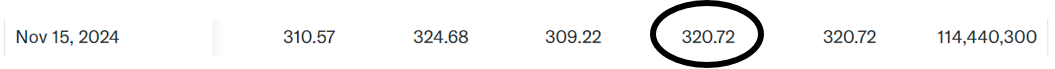

##**General Conclusions**
**The Polynomial Regression with Ridge regularization model provides the most accurate prediction (with a deviation of 1.16), followed by the Linear Regression model (with a deviation of 1.20).** The Polynomial Regression with Lasso regularization gives the most distant prediction (with a deviation of 2.22). Therefore, the Polynomial Regression with Ridge regularization appears to be the best model, as it offers the most accurate prediction, closely aligning with the actual closing price.